In [69]:
# Verify library versions
import tdt
import neurokit2 as nk
from neurokit2 import signal_filter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import signal_processing as sp
import importlib

print("TDT version:", tdt.__version__)
print("NeuroKit2 version:", nk.__version__)
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)

TDT version: 0.6.6
NeuroKit2 version: 0.2.10
NumPy version: 1.26.4
Pandas version: 2.2.3
Matplotlib version: 3.10.0


In [70]:
tdt_path = r"E:\resp_test_data\mouse5-250125-100112"
mouse = tdt.read_block(tdt_path)

print(mouse)

Found Synapse note file: E:\resp_test_data\mouse5-250125-100112\Notes.txt
read from t=0s to t=302.25s
epocs	[struct]
snips	[struct]
streams	[struct]
scalars	[struct]
info	[struct]
time_ranges:	array([[ 0.],
       [inf]])


In [71]:
print(f"streams data: {mouse.streams.keys()}")
print(f"epocs: {mouse.epocs.keys()}")
print(f"info data: {mouse.info.keys()}")
print(f"scalar data: {mouse.scalars.keys()}")
print(f"snips data: {mouse.snips.keys()}")

streams data: dict_keys(['Resp'])
epocs: dict_keys(['Cam1', 'Tick'])
info data: dict_keys(['tankpath', 'blockname', 'start_date', 'utc_start_time', 'stop_date', 'utc_stop_time', 'duration', 'stream_channel', 'snip_channel', 'experiment', 'subject', 'user', 'start', 'stop'])
scalar data: dict_keys([])
snips data: dict_keys([])


In [72]:
print(dir(mouse.streams['Resp']))

['__bool__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__ior__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__or__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__ror__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'channel', 'clear', 'code', 'copy', 'data', 'dform', 'fromkeys', 'fs', 'get', 'items', 'keys', 'name', 'pop', 'popitem', 'setdefault', 'size', 'start_time', 'type', 'type_str', 'ucf', 'update', 'values']


In [73]:
# Calling it ecg stream for now, not sure if it's actually resp or not  
ecg_stream = mouse.streams['Resp']

# Extract key attributes
resp_data = ecg_stream.data
fs = ecg_stream.fs
start_time = ecg_stream.start_time
data_shape = ecg_stream.data.shape
size = ecg_stream.size
channel = ecg_stream.channel
stream_name = ecg_stream.name


In [74]:
# Apply the custom filtering logic
rsp_cleaned = nk.signal_filter(
    resp_data,
    lowcut=0.1,   # Low cutoff frequency (Hz)
    highcut=20,   # High cutoff frequency (Hz)
    method="butterworth",  # Filtering method
    sampling_rate=fs,
    order=2  # Filter order
)

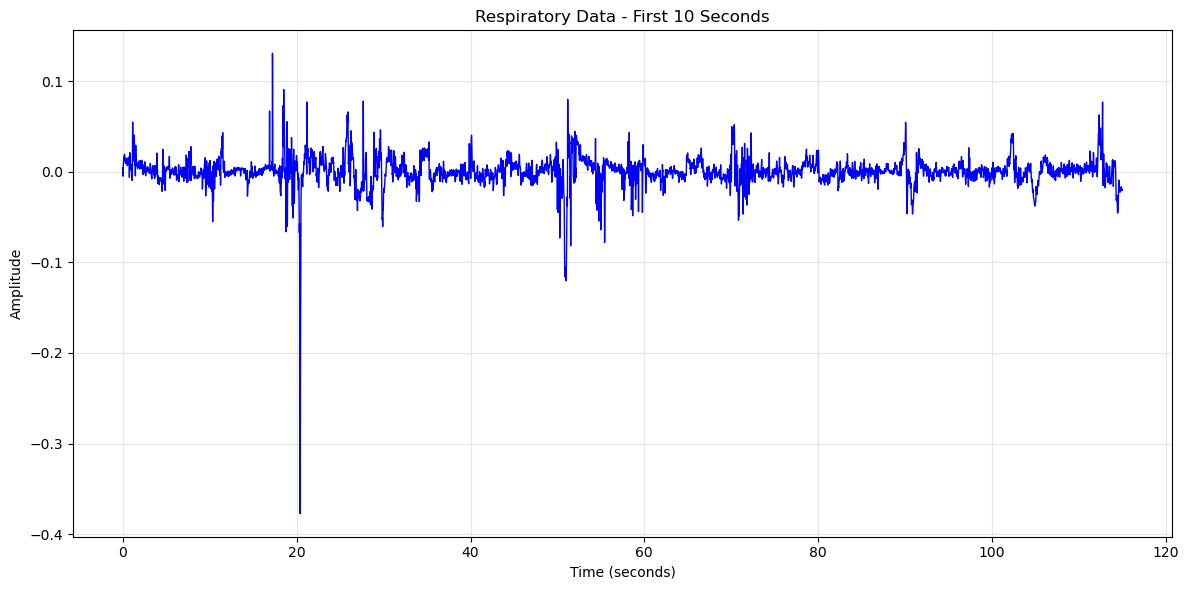

In [75]:
n_samples = int(115 * fs)

# Create time array for x-axis
time = np.arange(n_samples) / fs + start_time

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(time, rsp_cleaned[:n_samples], 'b-', linewidth=1)

# Add labels and title
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title(f'Respiratory Data - First {10} Seconds')

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

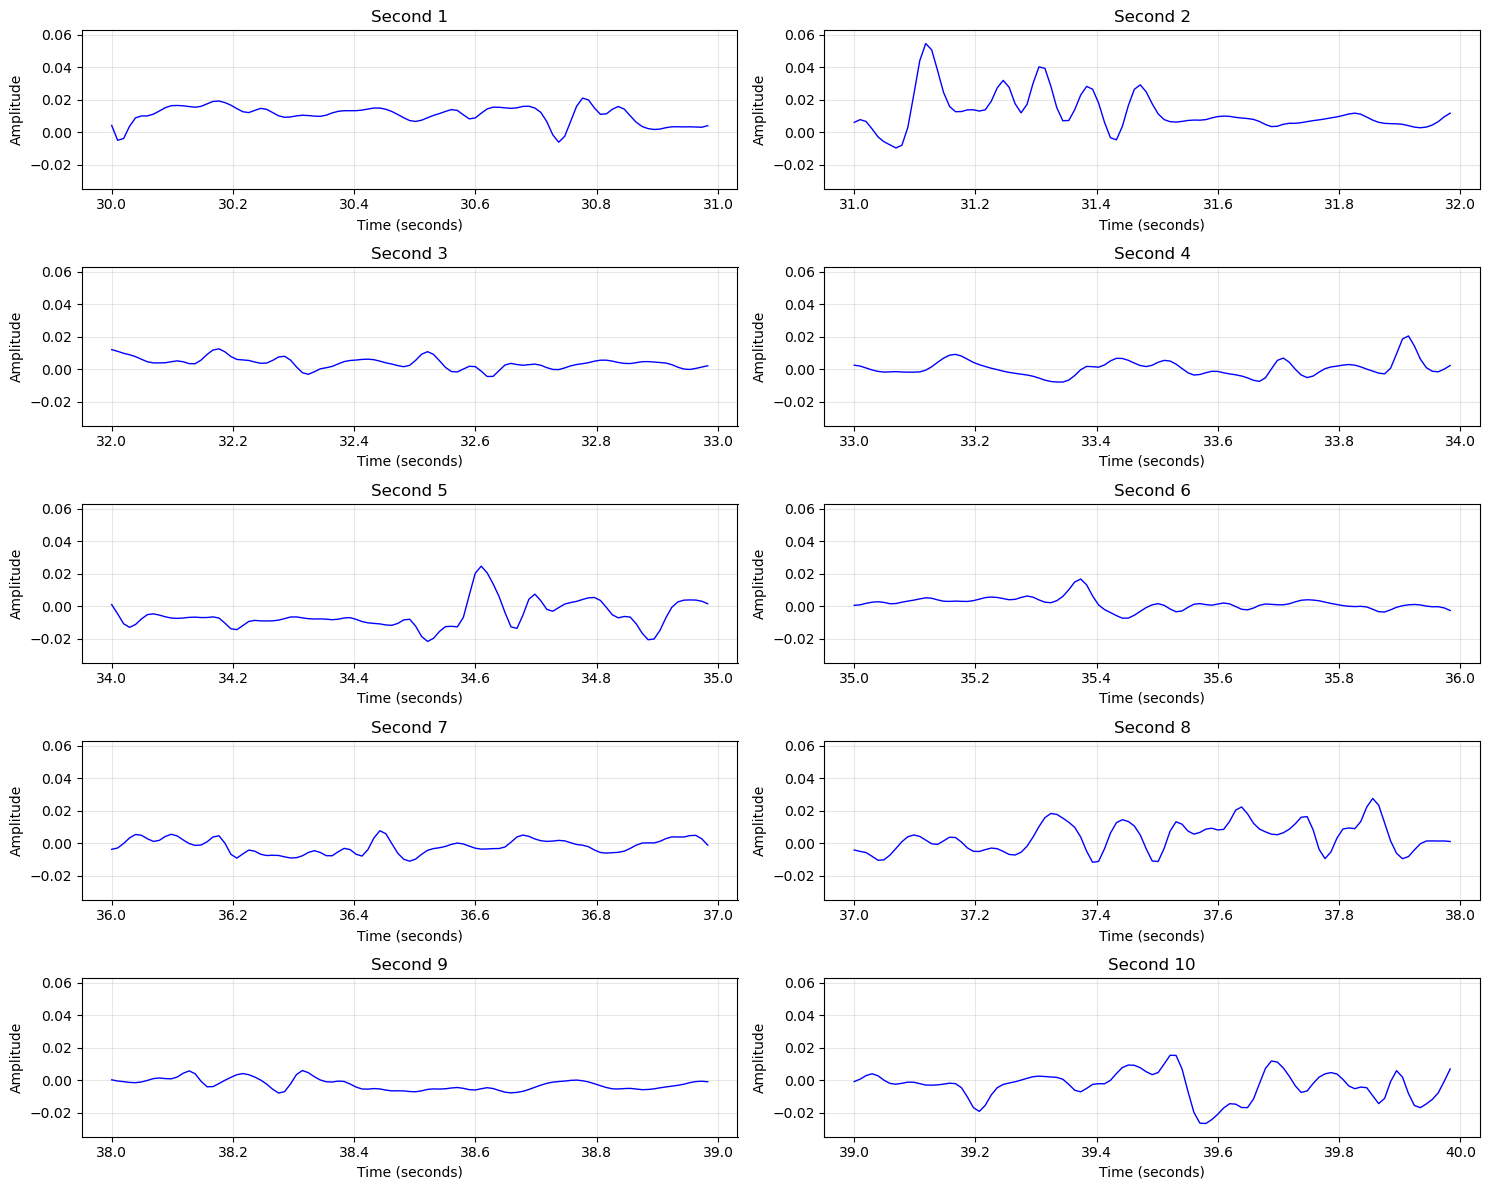

In [76]:
import resp_plotting
import importlib
importlib.reload(resp_plotting)

resp_plotting.plot_respiratory_data_by_second(rsp_cleaned, fs, start_time = 30)


In [77]:
def peakfinder(x0, sel=None, thresh=None, extrema=1, include_endpoints=True, interpolate=False):
    """
    Python version of MATLAB's peakfinder function.

    Parameters:
        x0: array-like
            A real vector where peaks will be identified.
        sel: float, optional
            The selectivity threshold. Peaks must be this much above surrounding data.
            Default is (max(x0) - min(x0)) / 4.
        thresh: float, optional
            Peaks must be larger (or smaller for minima) than this value.
        extrema: int, optional
            1 to find maxima, -1 to find minima. Default is 1.
        include_endpoints: bool, optional
            Include endpoints as possible extrema. Default is True.
        interpolate: bool, optional
            Perform quadratic interpolation around each extrema. Default is False.

    Returns:
        peak_inds: numpy.ndarray
            Indices of the identified peaks.
        peak_mags: numpy.ndarray
            Magnitudes of the identified peaks.
    """
    x0 = np.asarray(x0, dtype=float)
    
    if x0.ndim != 1:
        raise ValueError("Input data must be a 1D array.")
    if not np.isreal(x0).all():
        warnings.warn("Absolute value of data will be used.", RuntimeWarning)
        x0 = np.abs(x0)
    
    if sel is None:
        sel = (np.max(x0) - np.min(x0)) / 4
    if thresh is None:
        thresh = np.nan
    if extrema not in [1, -1]:
        raise ValueError("extrema must be 1 (maxima) or -1 (minima).")
    
    x0 = extrema * x0  # Adjust for finding maxima/minima
    thresh *= extrema
    
    # Compute first derivative and find zero crossings
    dx0 = np.diff(x0)
    dx0[dx0 == 0] = -np.finfo(float).eps  # Handle repeated values
    ind = np.where(dx0[:-1] * dx0[1:] < 0)[0] + 1

    # Include endpoints if needed
    if include_endpoints:
        ind = np.concatenate(([0], ind, [len(x0) - 1]))

    x = x0[ind]
    min_mag = np.min(x)
    left_min = min_mag

    peak_locs = []
    peak_mags = []
    found_peak = False
    temp_mag = min_mag
    
    # Peak finding loop
    for i in range(len(x) - 1):
        if found_peak:
            temp_mag = min_mag
            found_peak = False
        
        if x[i] > temp_mag and x[i] > left_min + sel:
            temp_loc = i
            temp_mag = x[i]
        
        if i + 1 < len(x) and x[i + 1] < left_min:
            left_min = x[i + 1]

        if x[i] > left_min + sel:
            found_peak = True
            peak_locs.append(ind[temp_loc])
            peak_mags.append(temp_mag)

    # Interpolate if needed
    if interpolate and len(peak_locs) > 0:
        peak_locs = np.array(peak_locs, dtype=float)
        peak_mags = np.array(peak_mags, dtype=float)
        for i in range(len(peak_locs)):
            if 1 <= peak_locs[i] < len(x0) - 1:
                x1, x2, x3 = x0[int(peak_locs[i]) - 1:int(peak_locs[i]) + 2]
                denom = 2 * (x1 - 2 * x2 + x3)
                if denom != 0:
                    peak_locs[i] += (x1 - x3) / denom
                    peak_mags[i] += ((x1 - x3) * (x1 - x3)) / (8 * denom)
    
    # Convert to numpy arrays
    peak_locs = np.array(peak_locs, dtype=float)
    peak_mags = np.array(peak_mags, dtype=float)

    # Apply threshold
    if not np.isnan(thresh):
        mask = peak_mags > thresh
        peak_locs = peak_locs[mask]
        peak_mags = peak_mags[mask]

    return peak_locs, peak_mags


In [78]:
# Detect peaks in respiratory signal
peak_inds, peak_mags = peakfinder(rsp_cleaned[:n_samples])

# Convert peak indices to time values
peak_times = time[peak_inds.astype(int)]


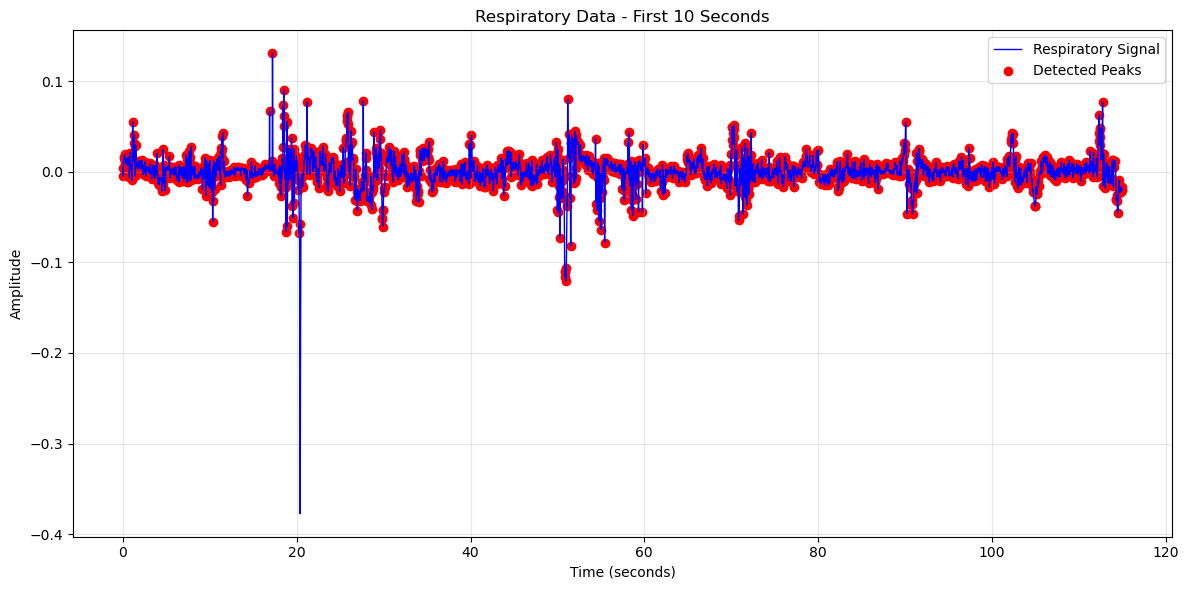

In [79]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(time, rsp_cleaned[:n_samples], 'b-', linewidth=1, label="Respiratory Signal")

# Plot detected peaks
plt.scatter(peak_times, peak_mags, color='red', marker='o', label="Detected Peaks")

# Add labels and title
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title(f'Respiratory Data - First {10} Seconds')

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Add legend
plt.legend()

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()


In [95]:
from scipy.signal import find_peaks

min_breath_interval = 1 / 15  # Minimum 15 Hz (about 900 BPM max)
min_distance = int(min_breath_interval * fs)

peak_inds, _ = find_peaks(rsp_cleaned[:n_samples], height=0, distance=min_distance)

peak_times = time[peak_inds]  # Convert to time
peak_mags = rsp_cleaned[peak_inds]  # Get amplitudes


In [99]:
# Compute time intervals between detected peaks
peak_intervals = np.diff(peak_times)

# Compute breathing rate (in Hz and breaths per minute)
breathing_rate_hz = 1 / np.mean(peak_intervals)
breathing_rate_bpm = breathing_rate_hz * 60

print(f"Estimated Breathing Rate: {breathing_rate_bpm:.2f} breaths per minute")
print(f"Estimated Breathing Rate: {breathing_rate_hz:.2f} breaths per second")

Estimated Breathing Rate: 418.76 breaths per minute
Estimated Breathing Rate: 6.98 breaths per second


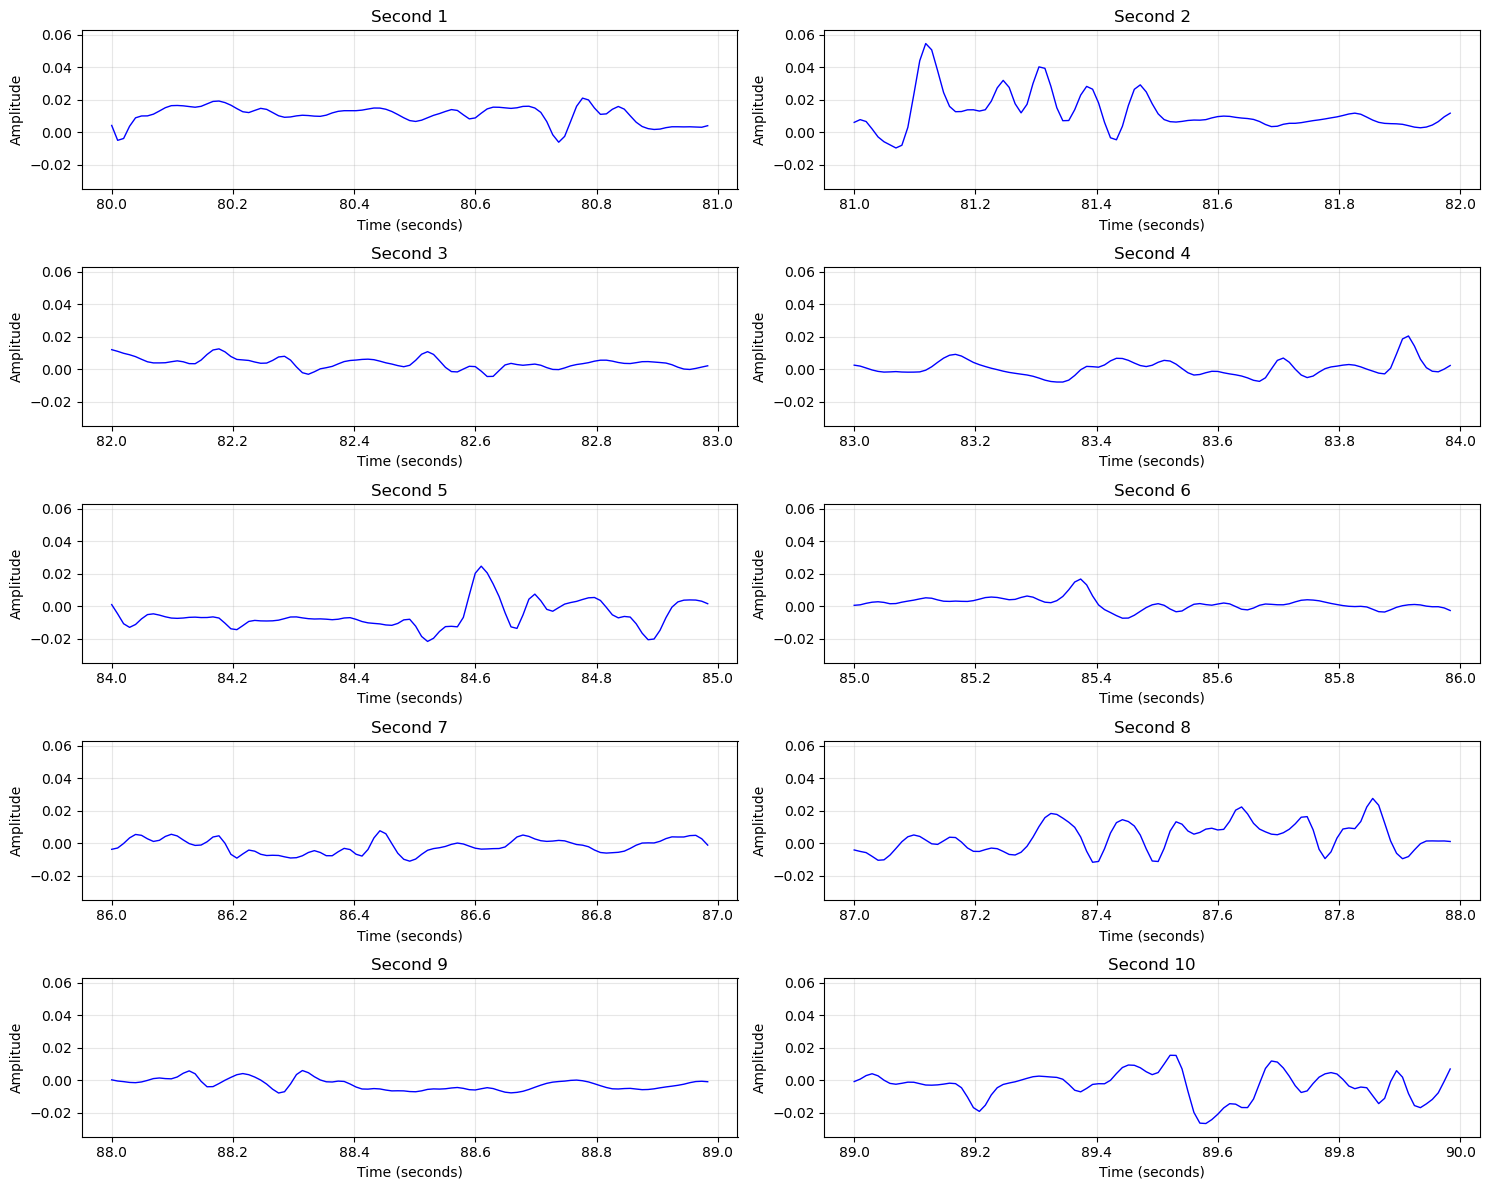

In [94]:
import resp_plotting
import importlib
importlib.reload(resp_plotting)

resp_plotting.plot_respiratory_data_by_second(rsp_cleaned, fs, start_time = 80)

c:\Users\sjs93\OneDrive\Documents\GitHub\respiratory_pilot\resp_plotting.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(5, 2, figsize=figsize)


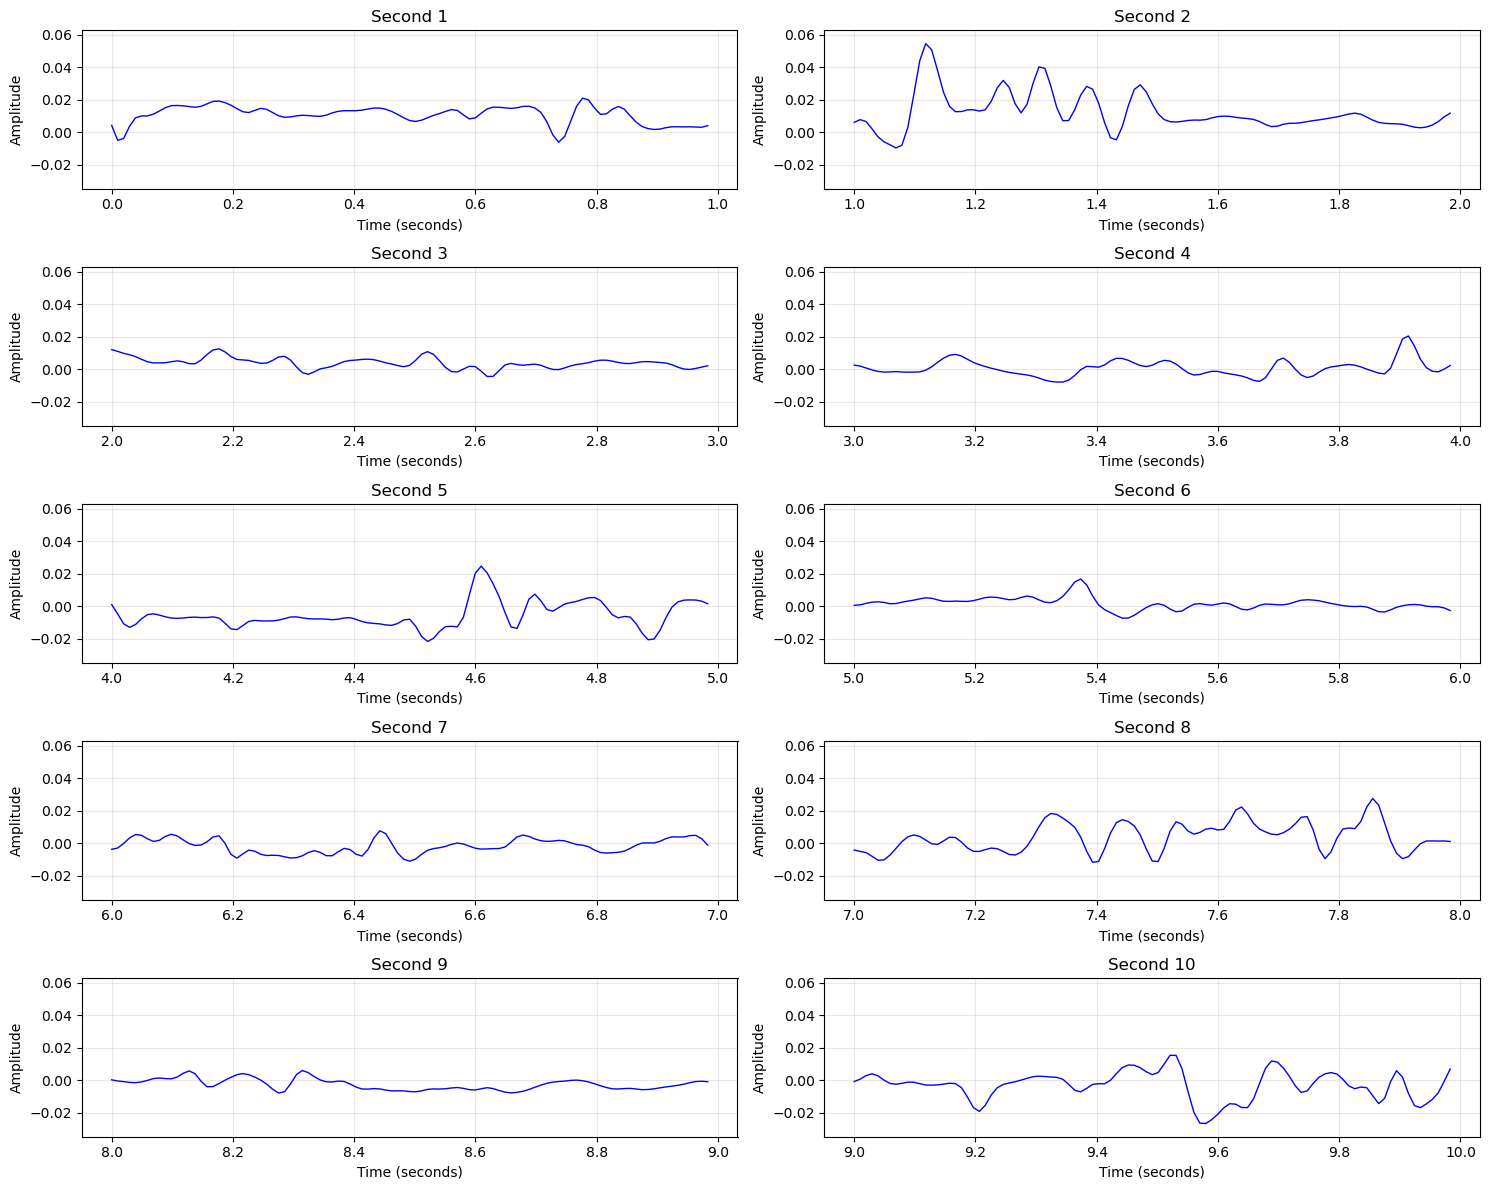

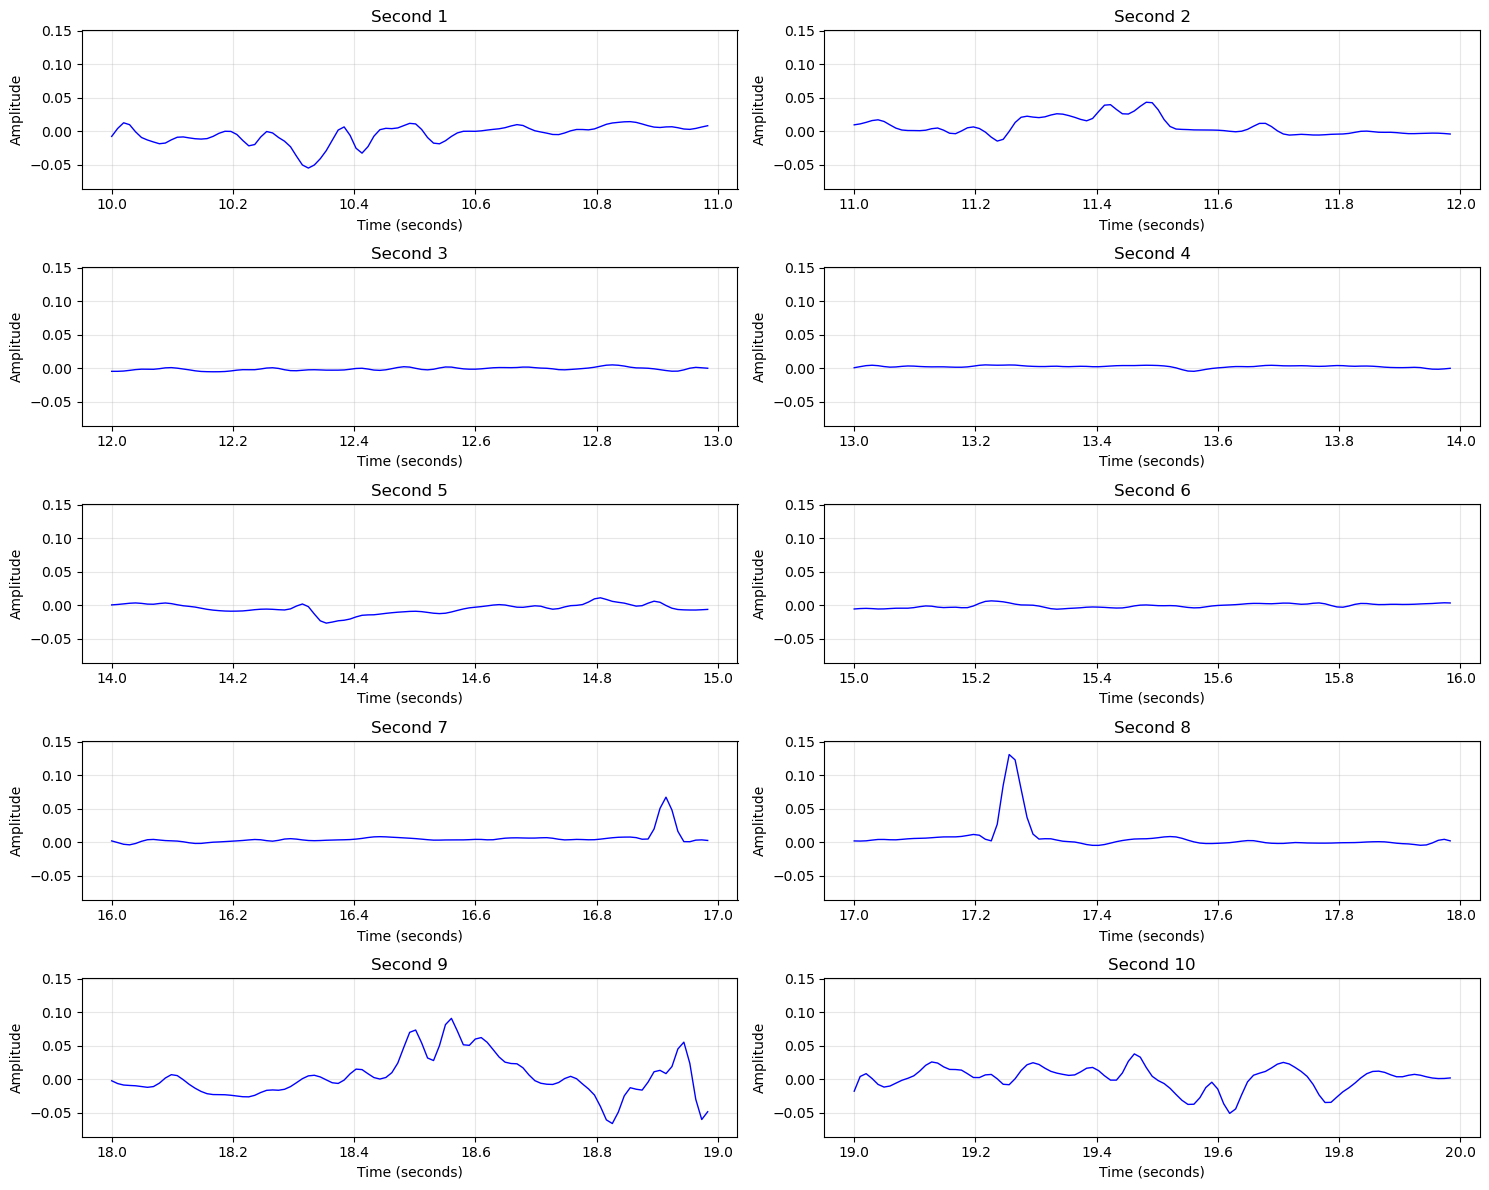

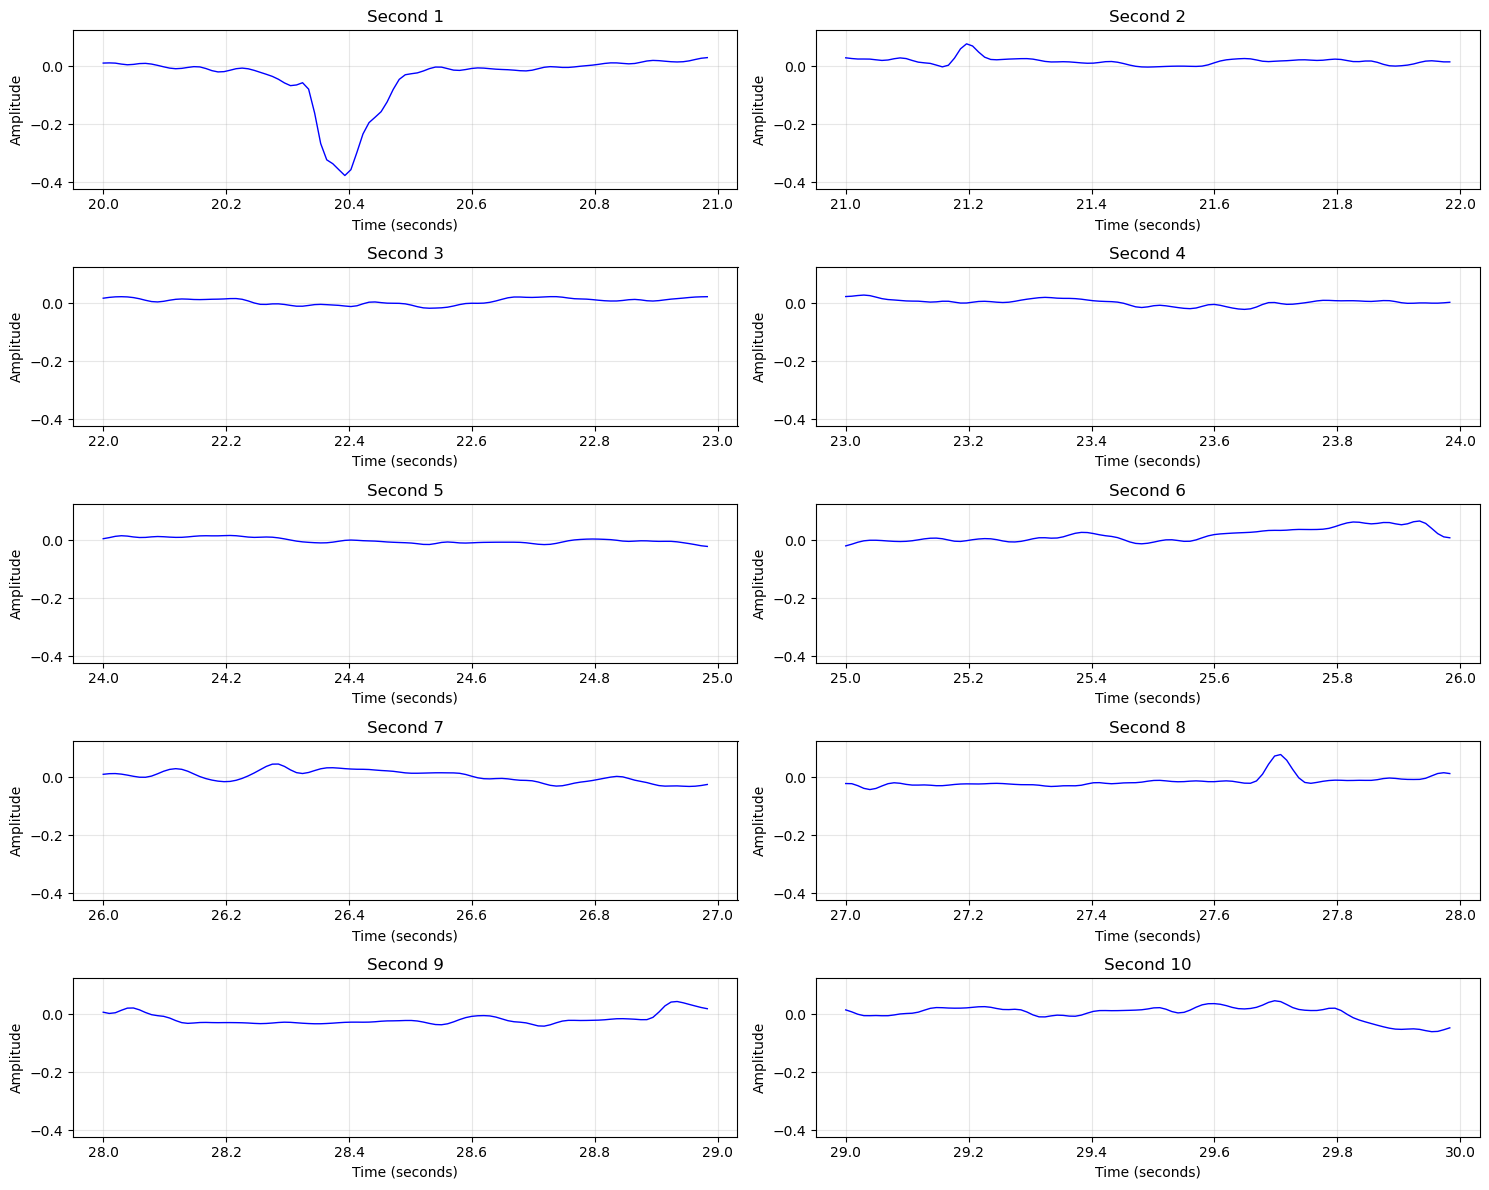

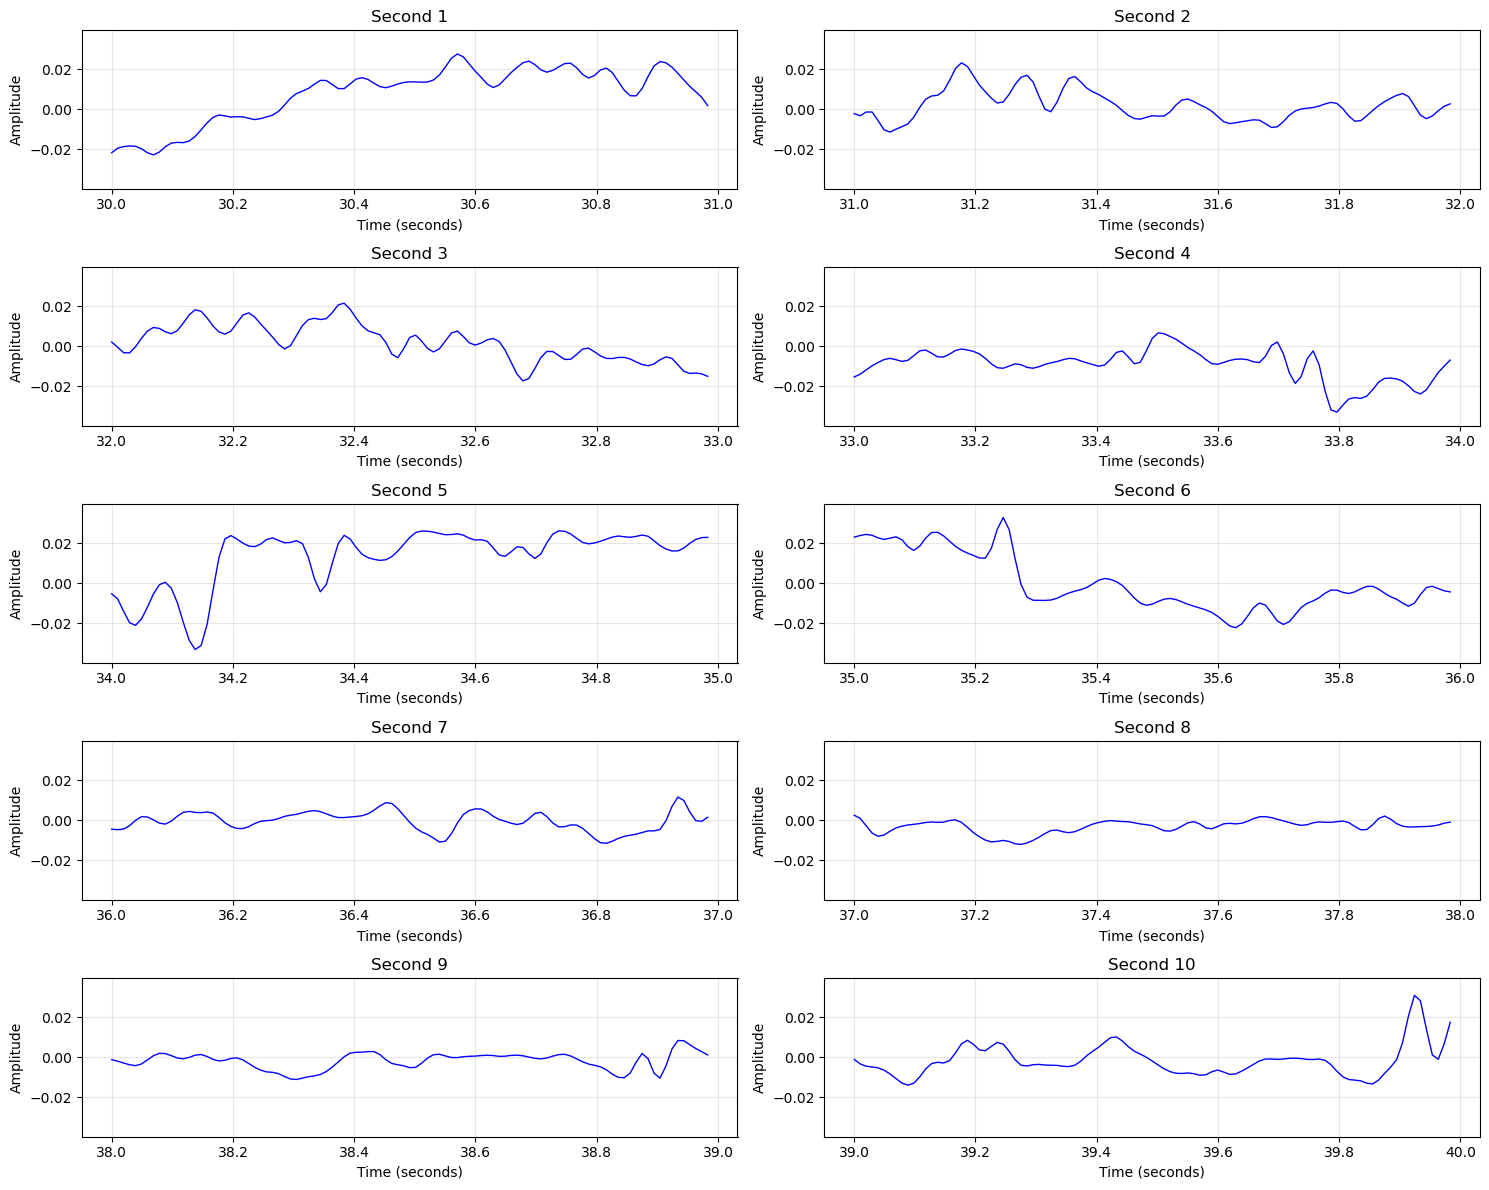

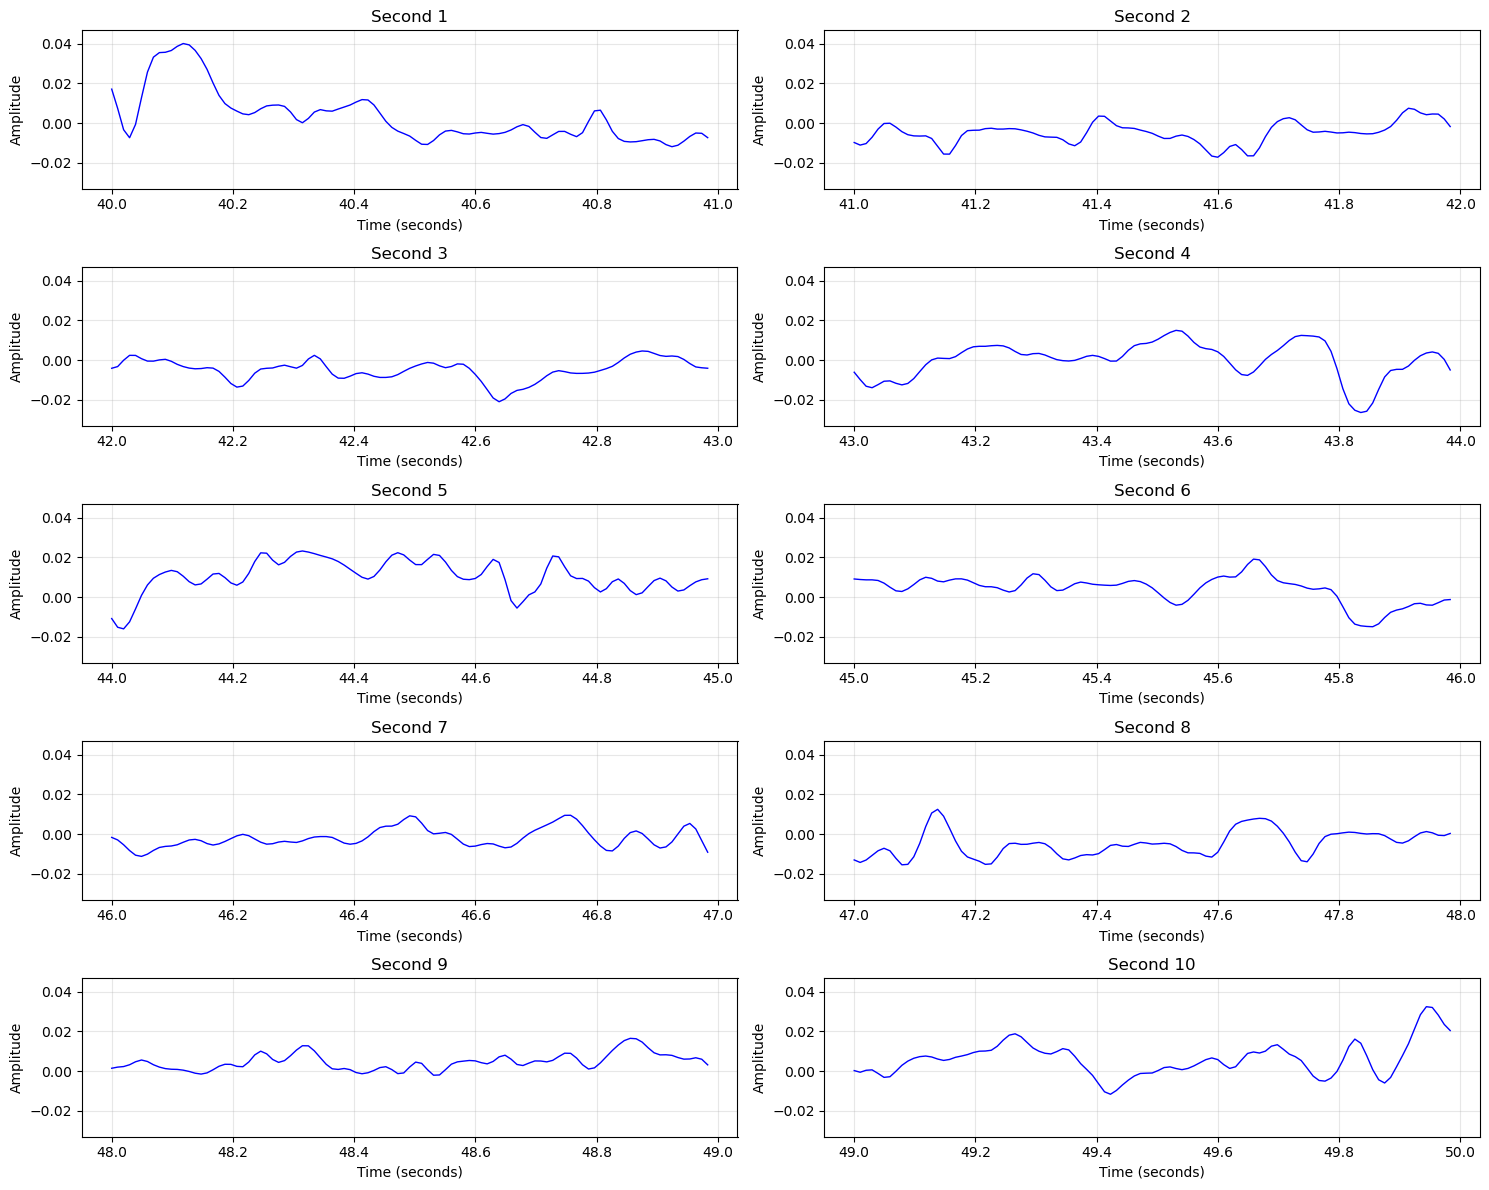

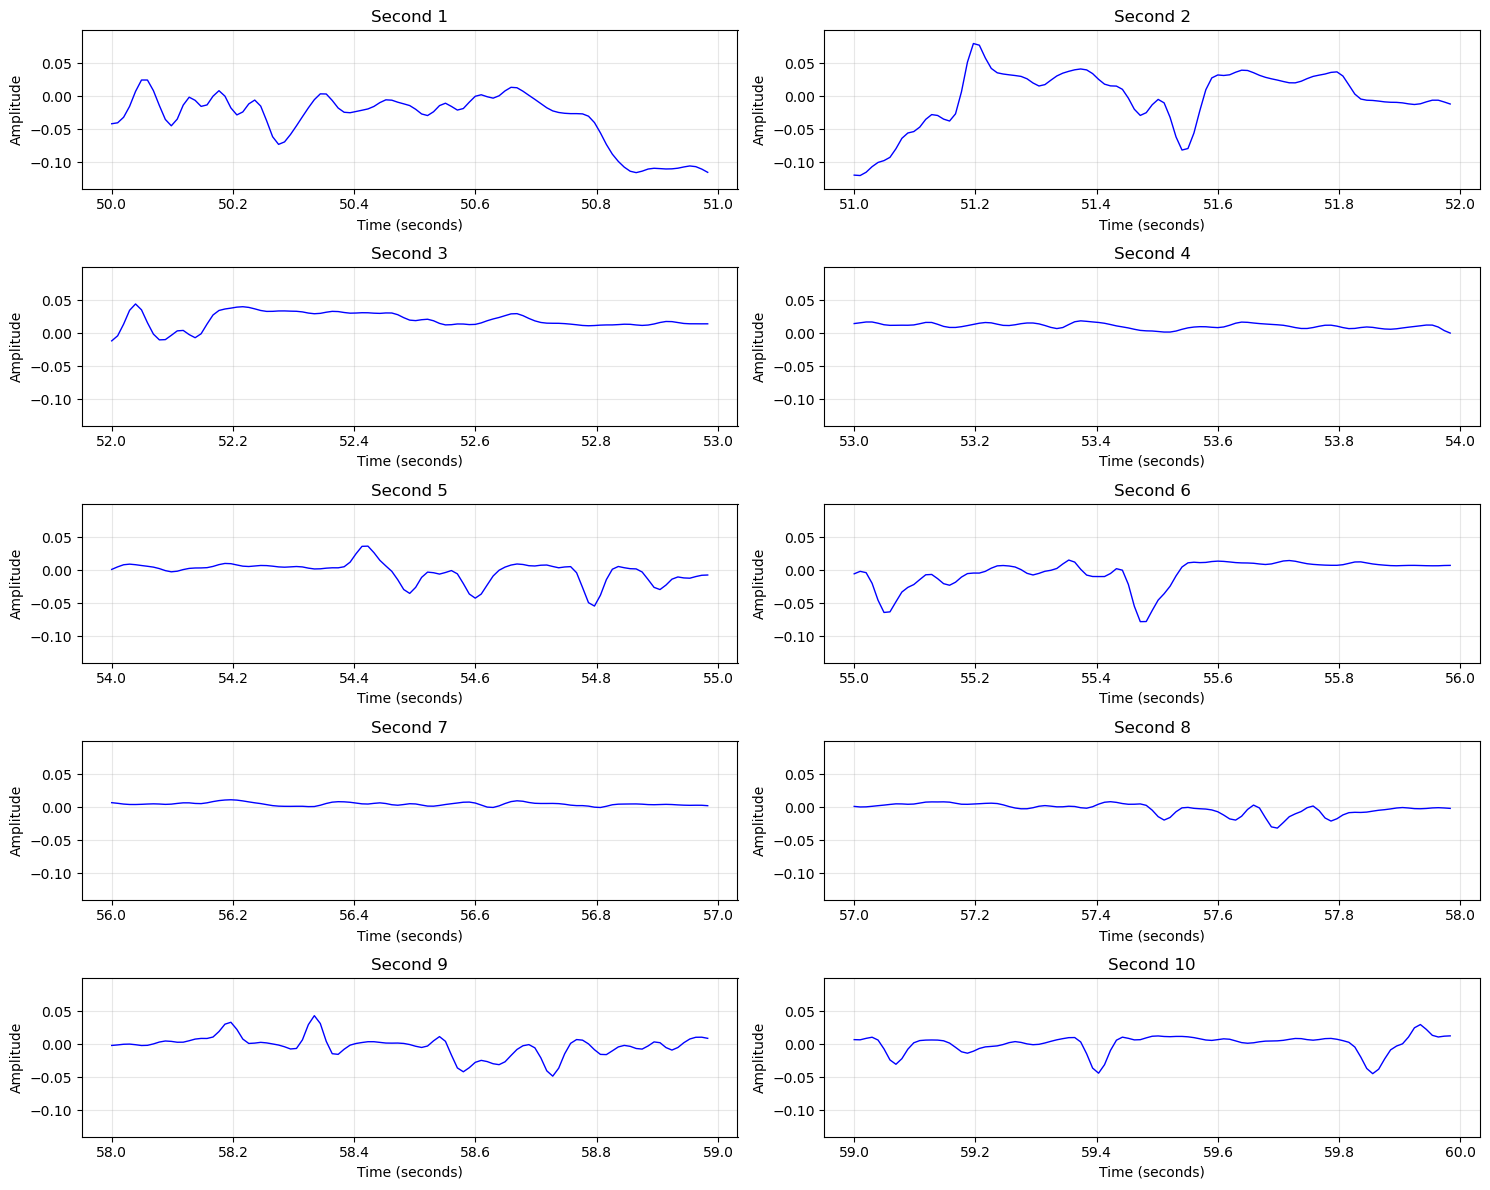

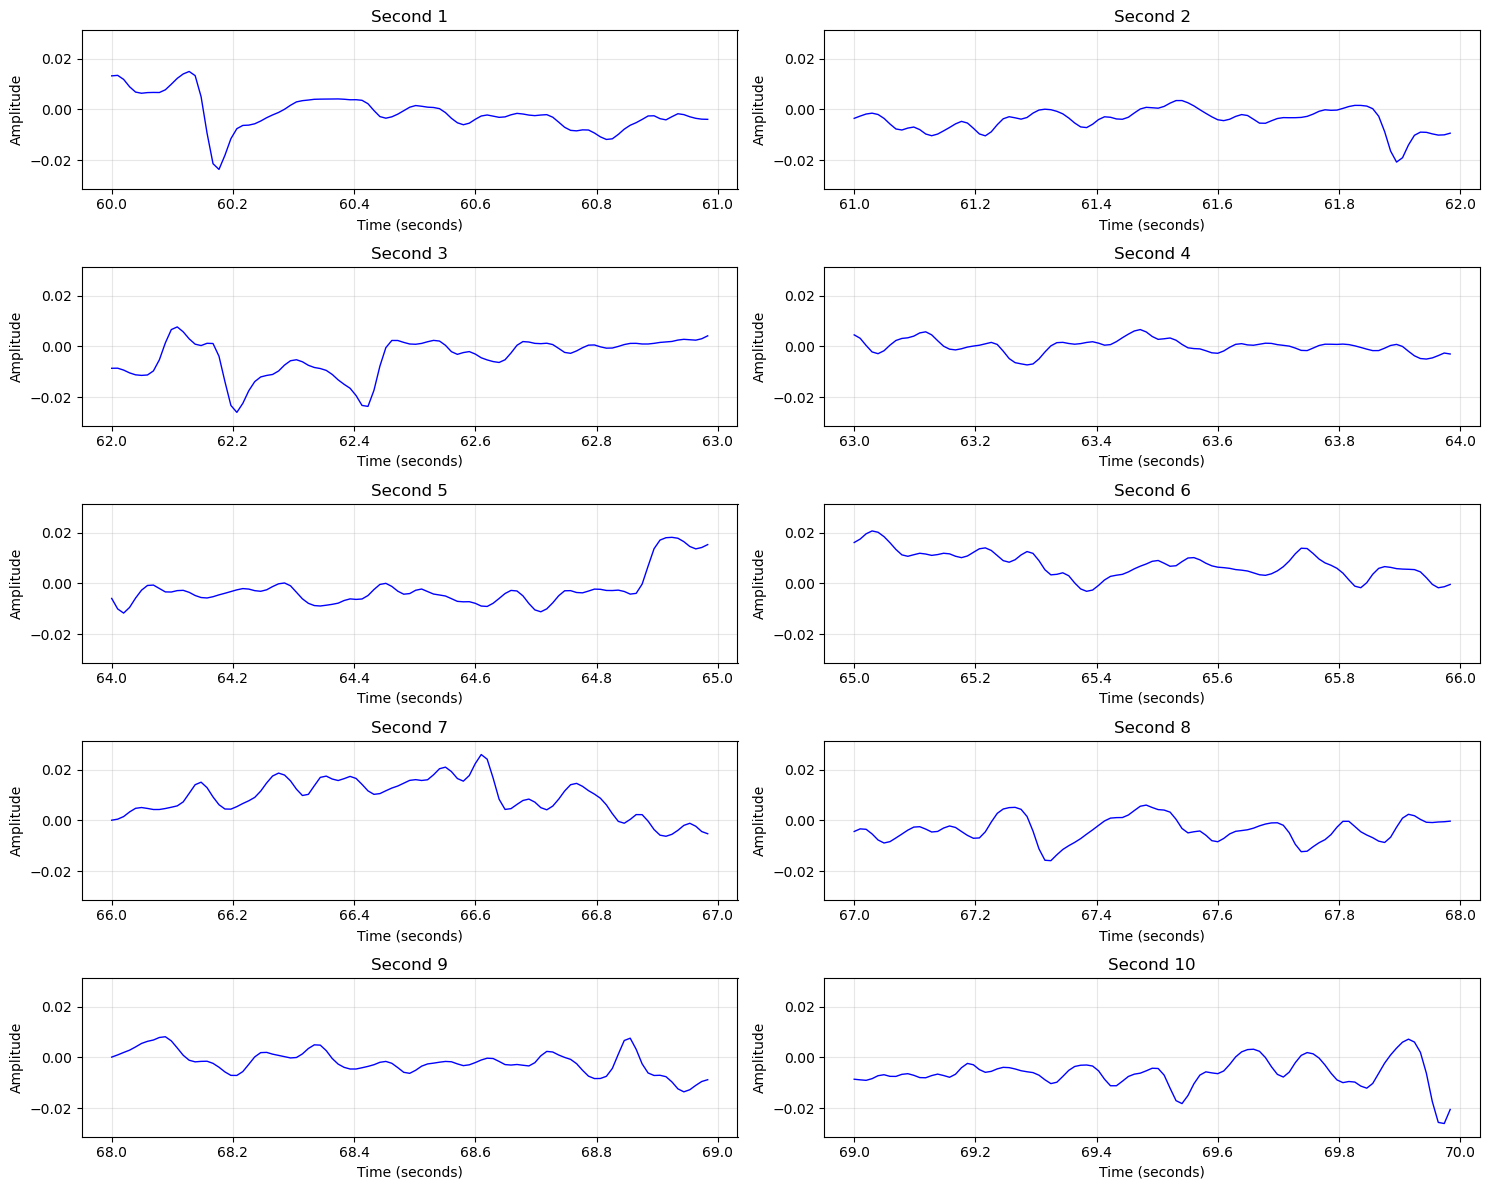

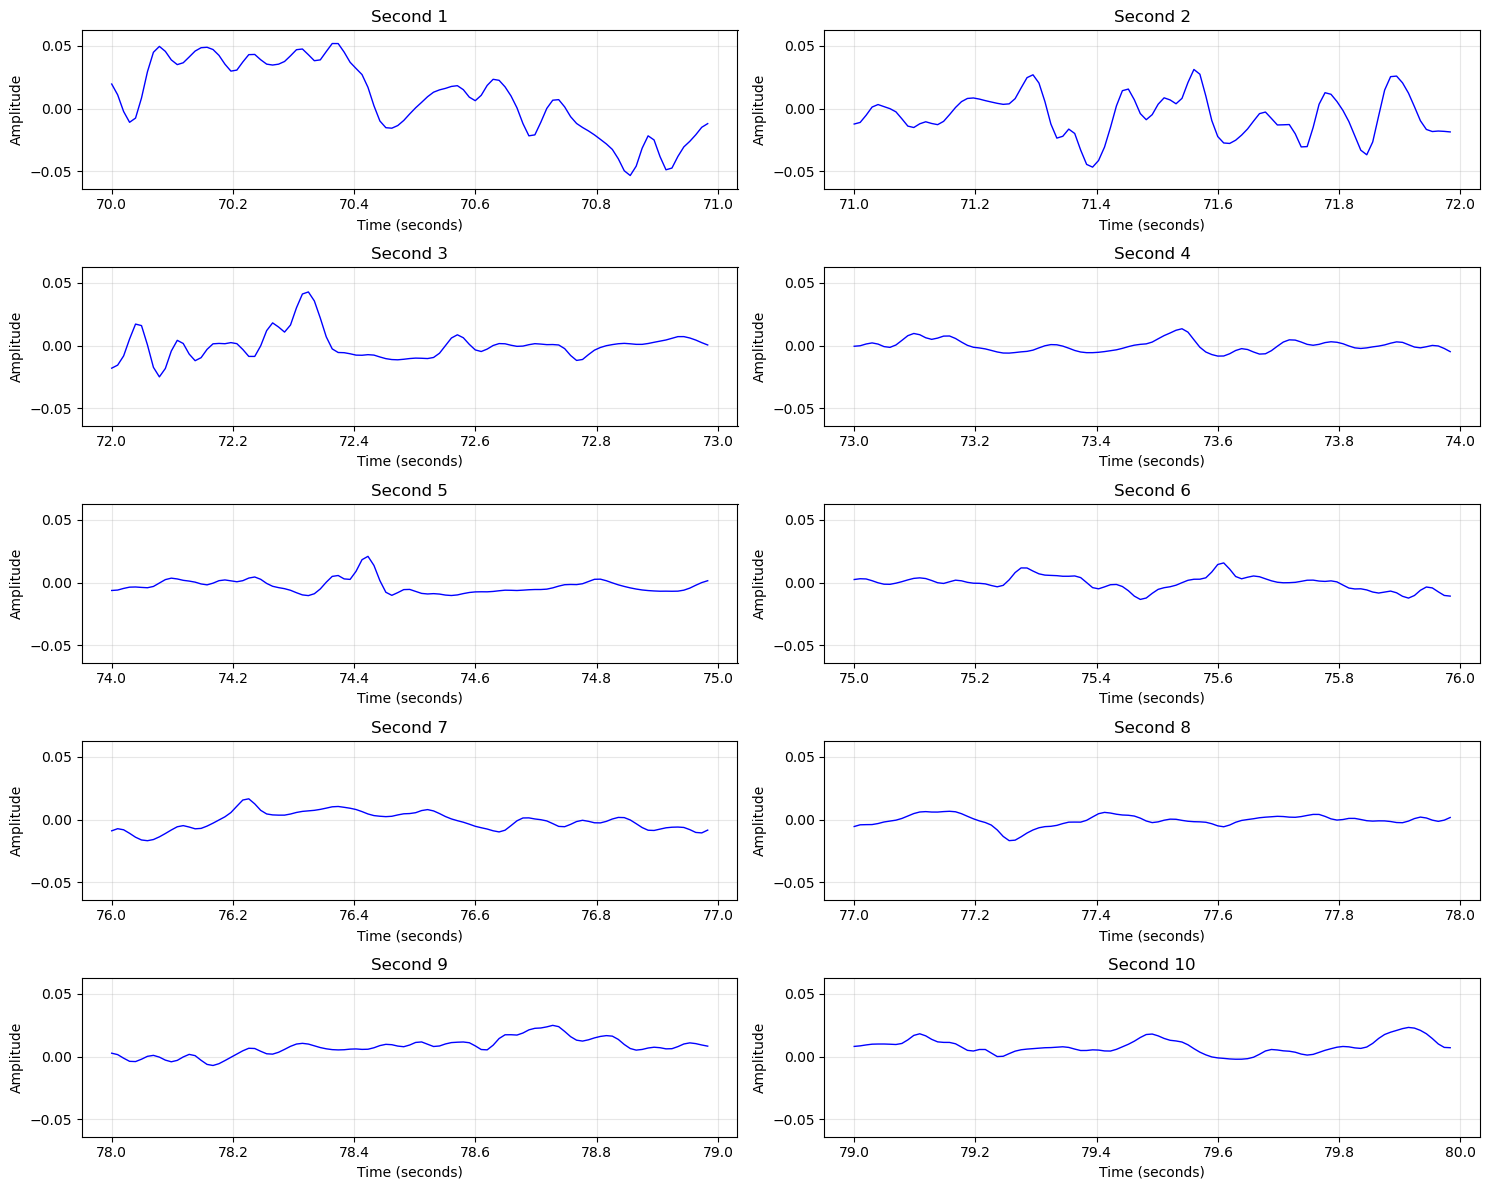

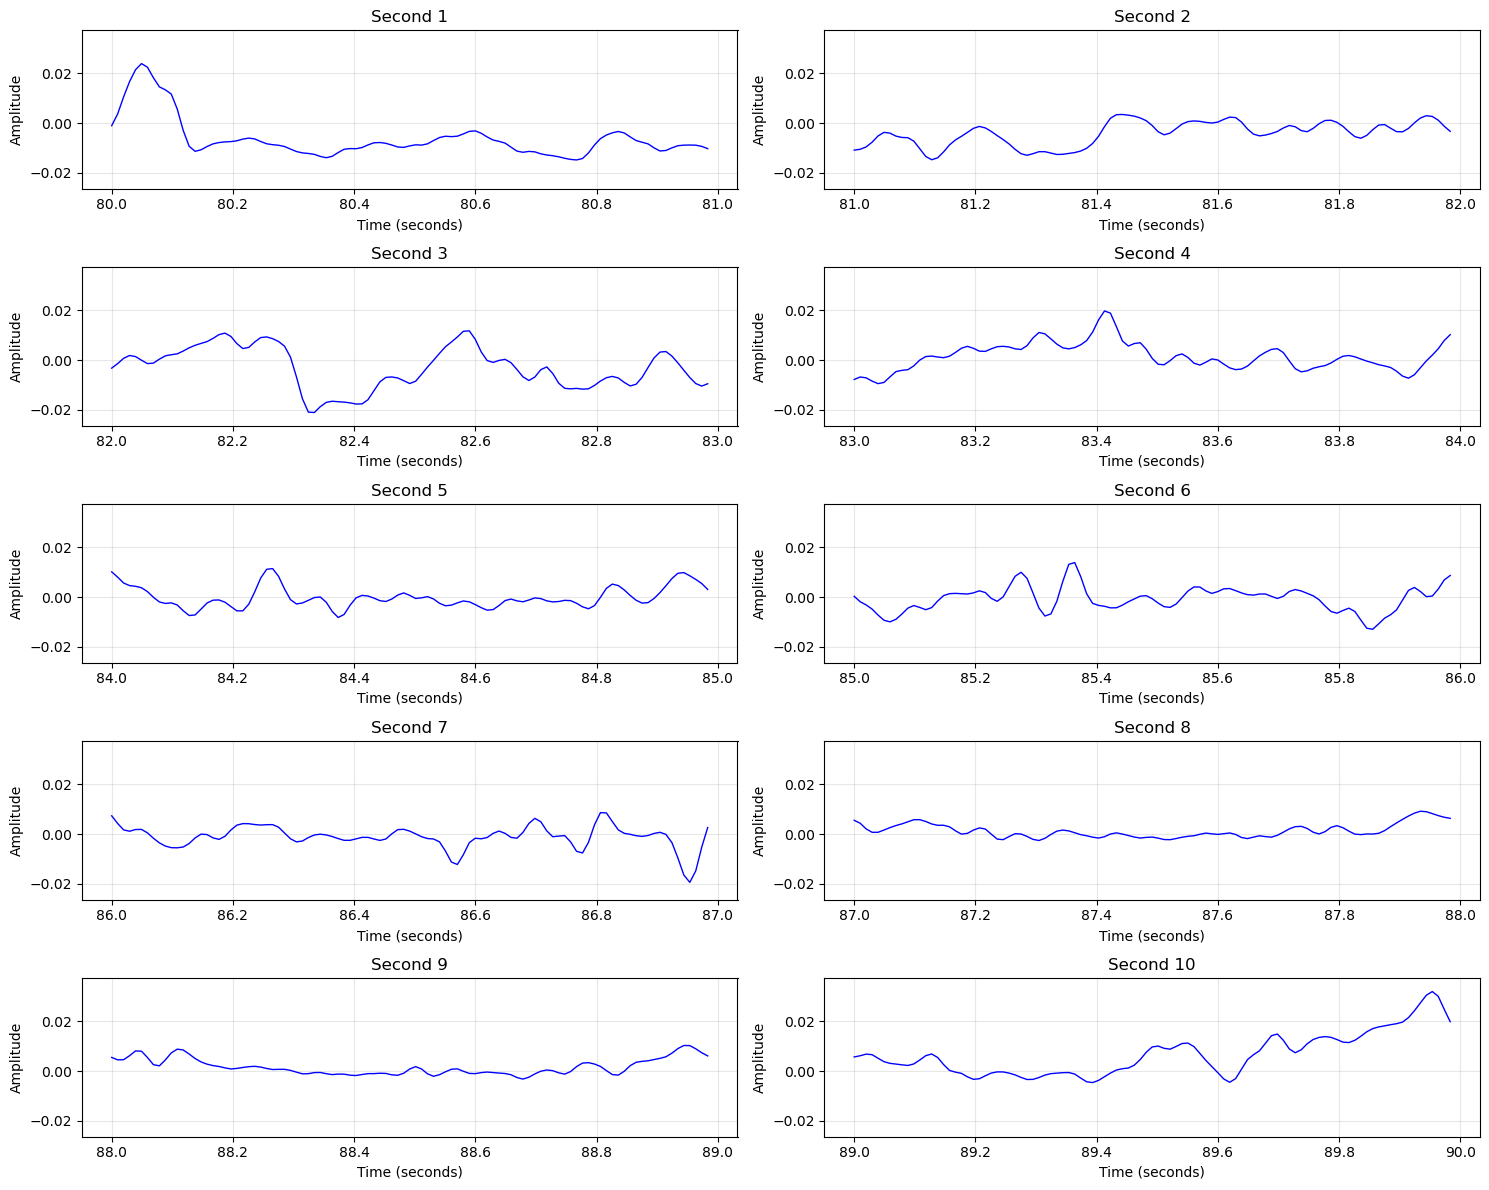

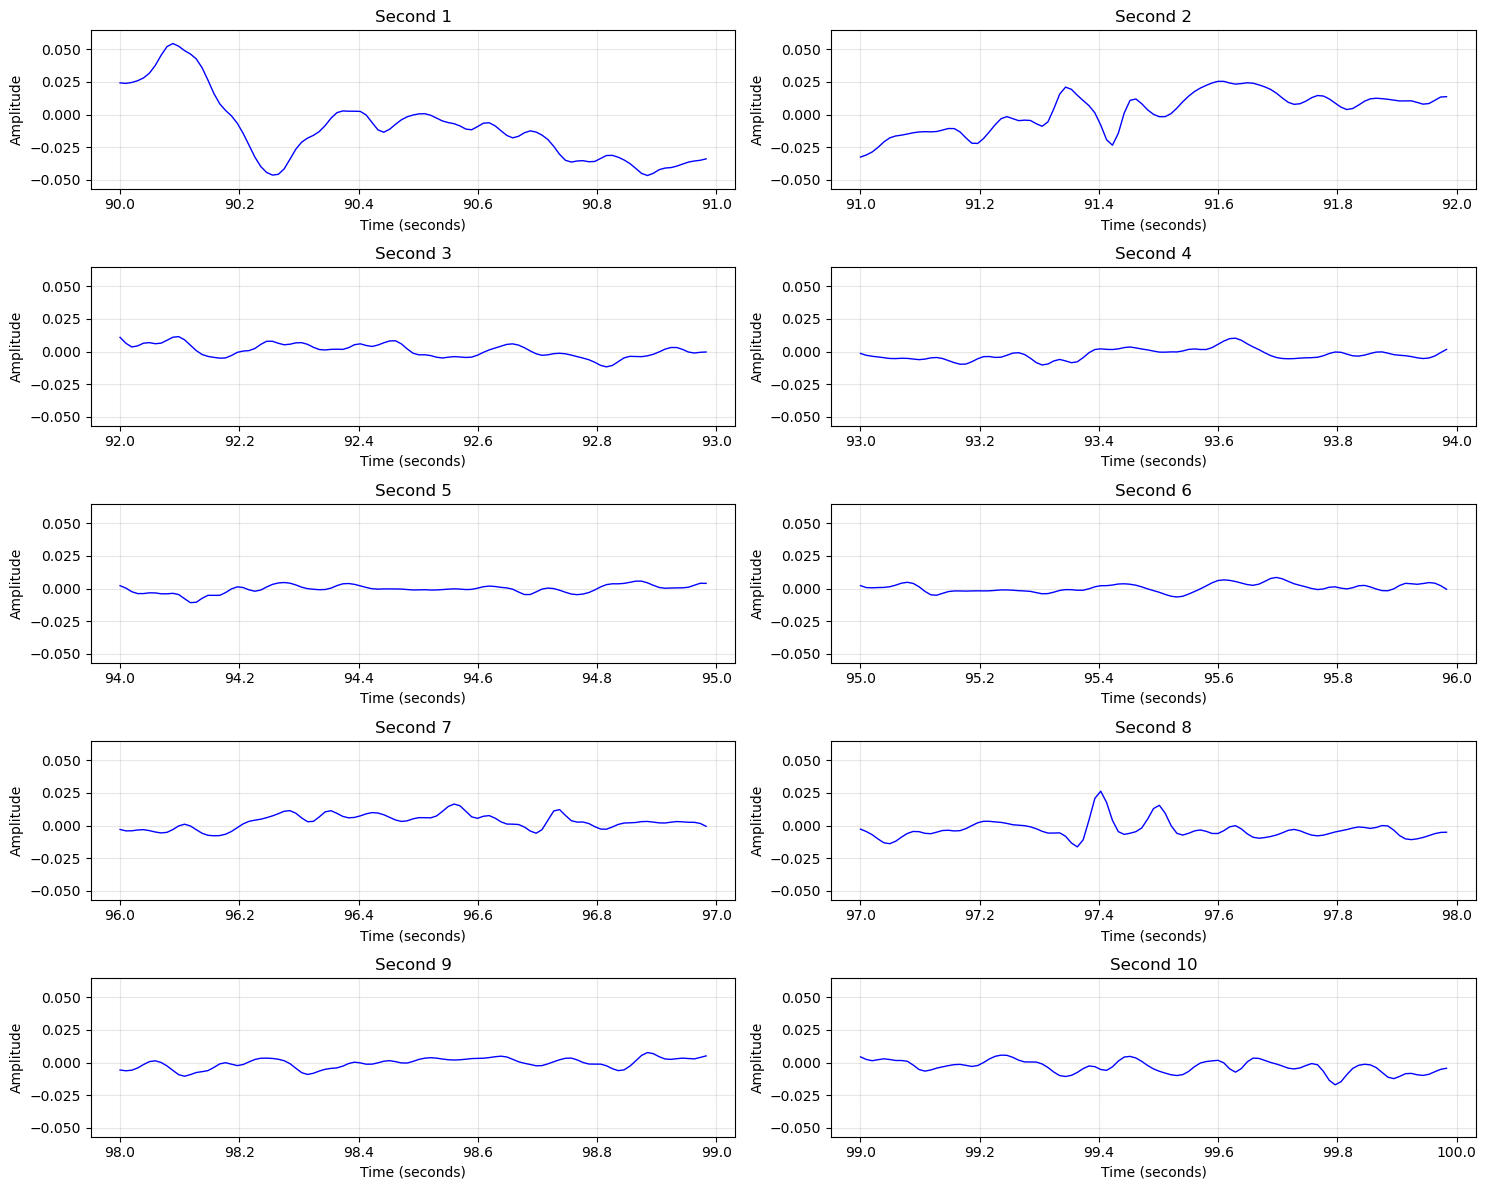

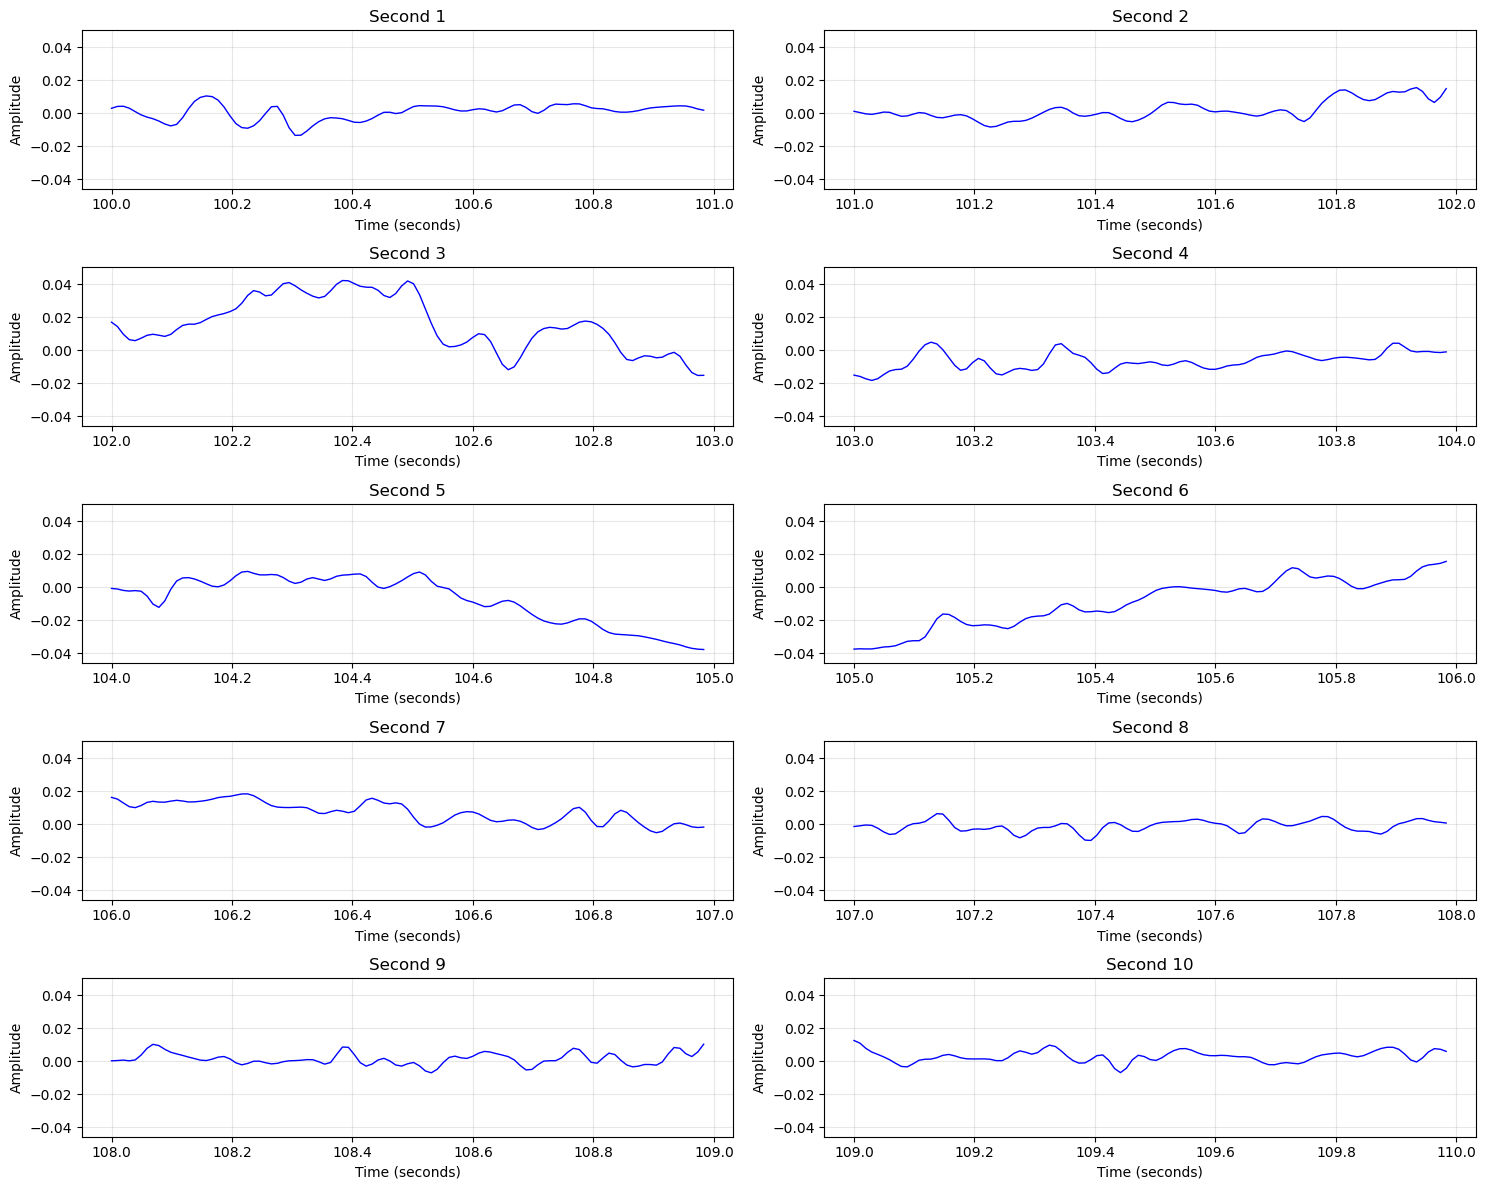

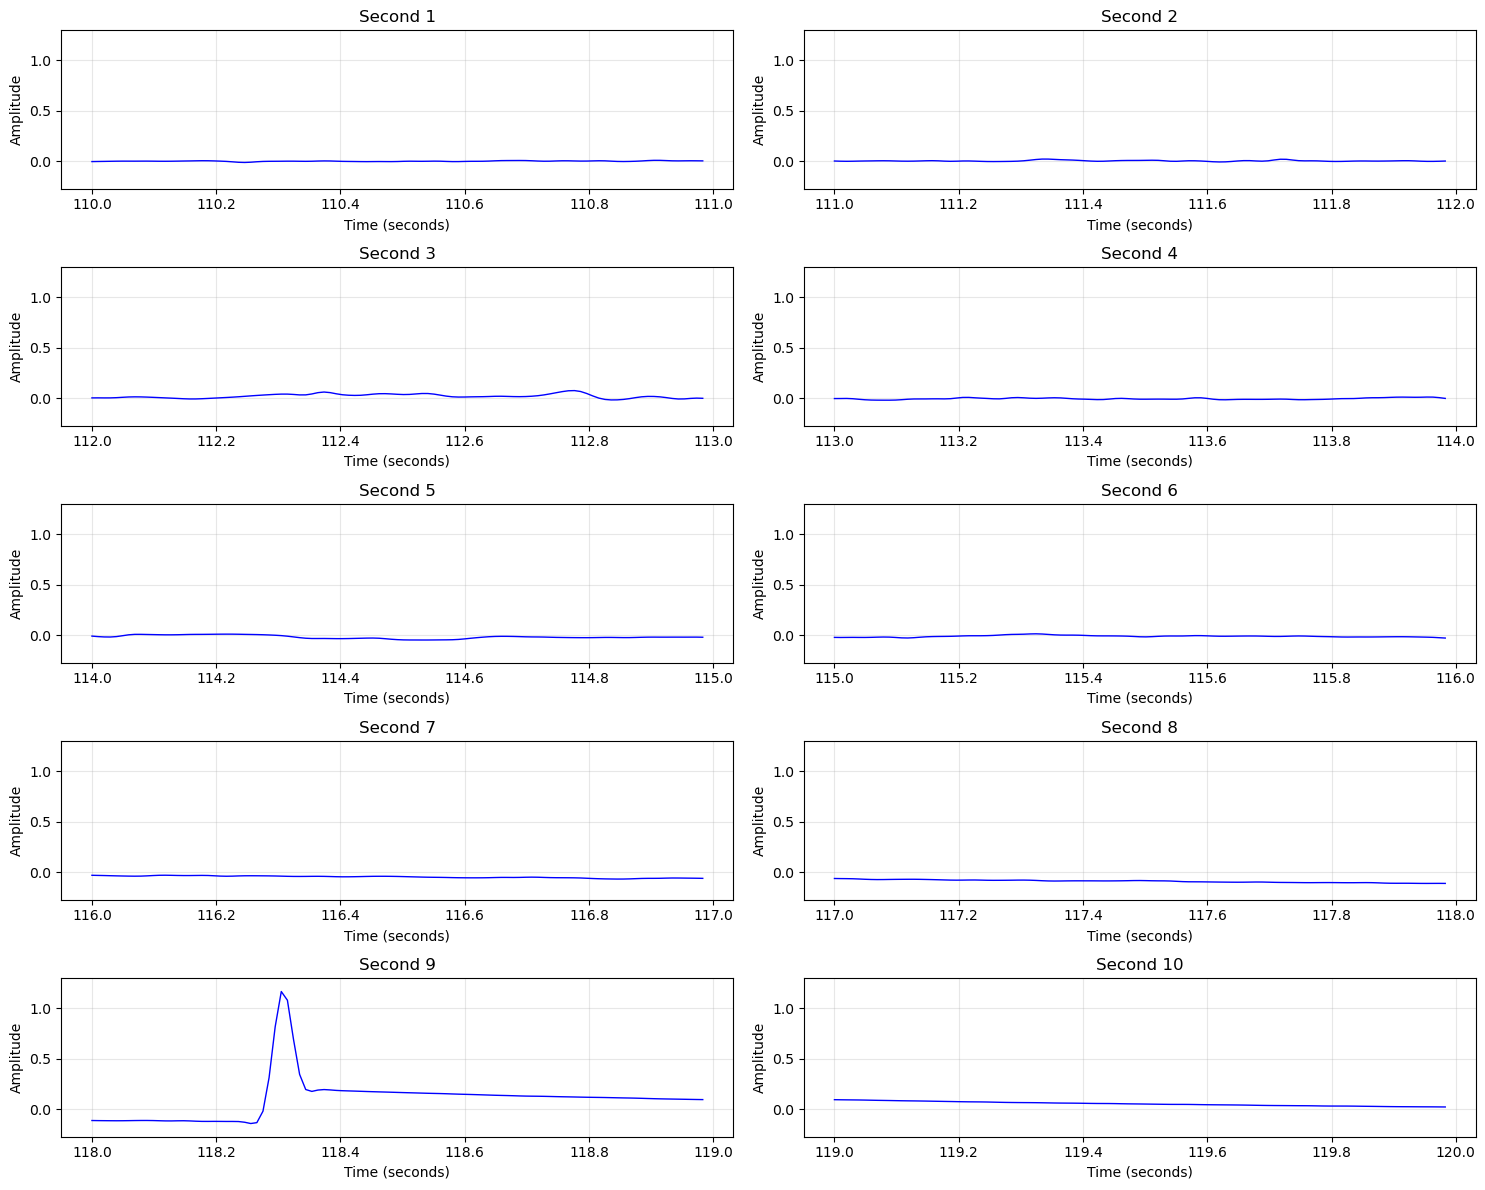

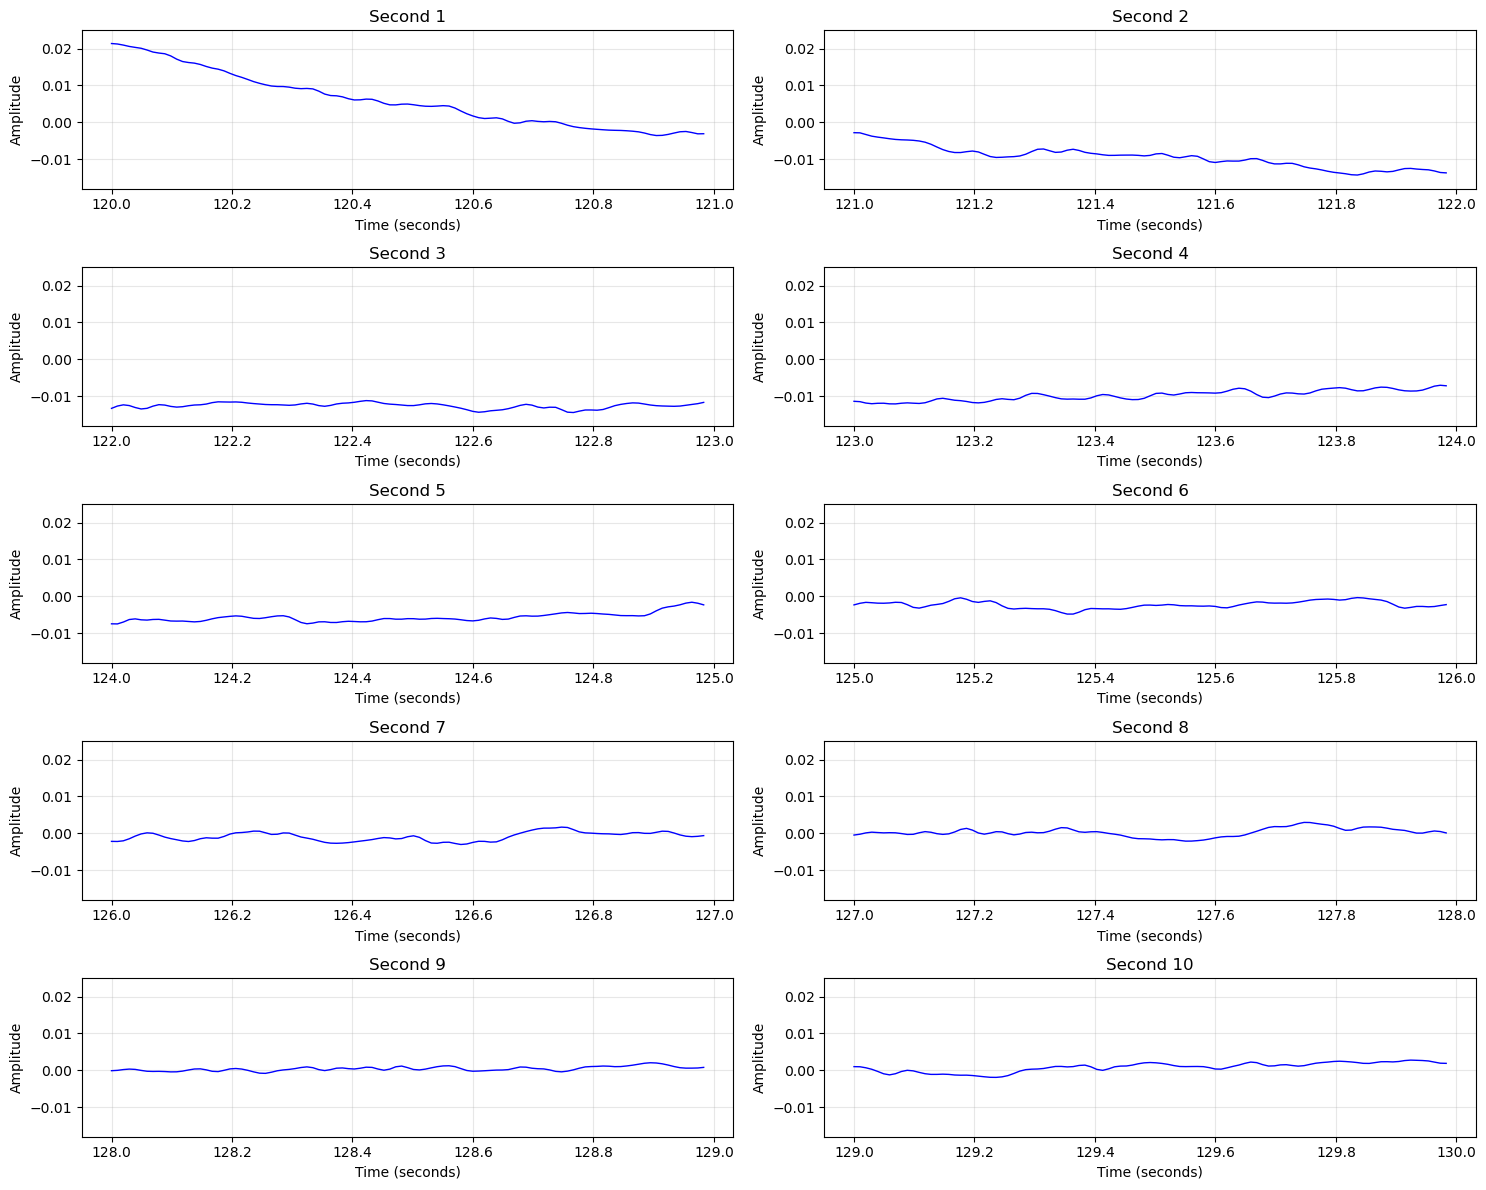

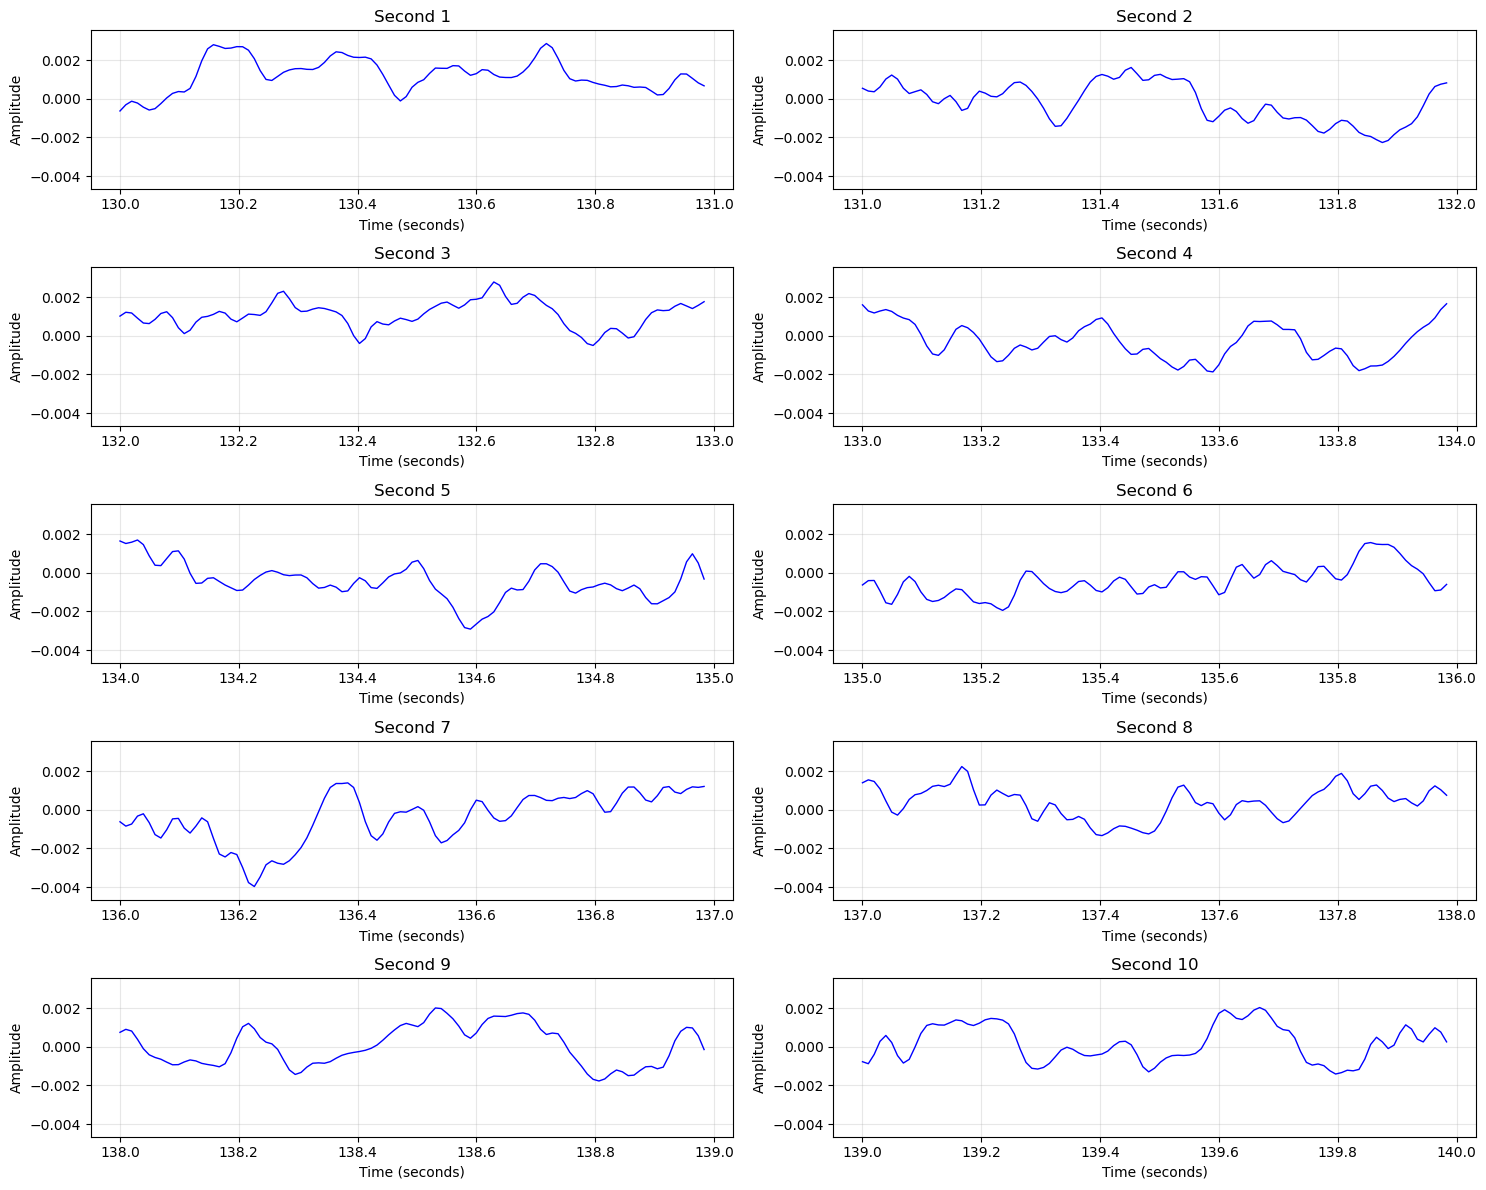

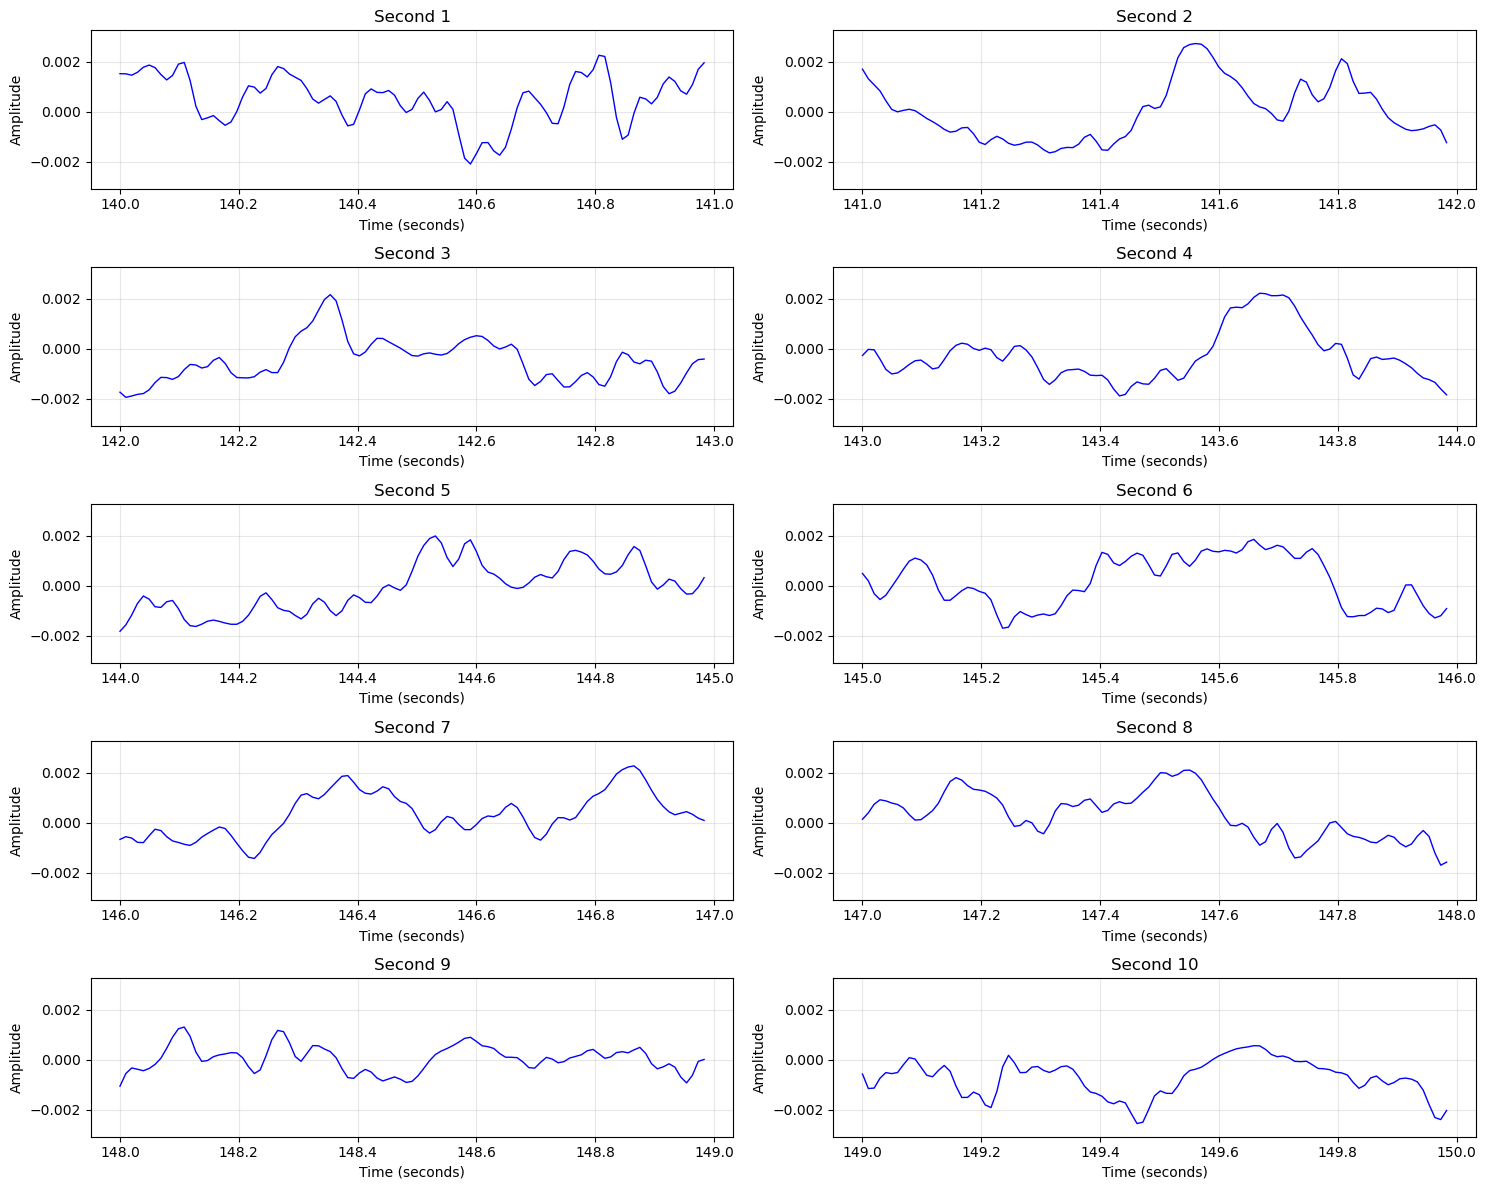

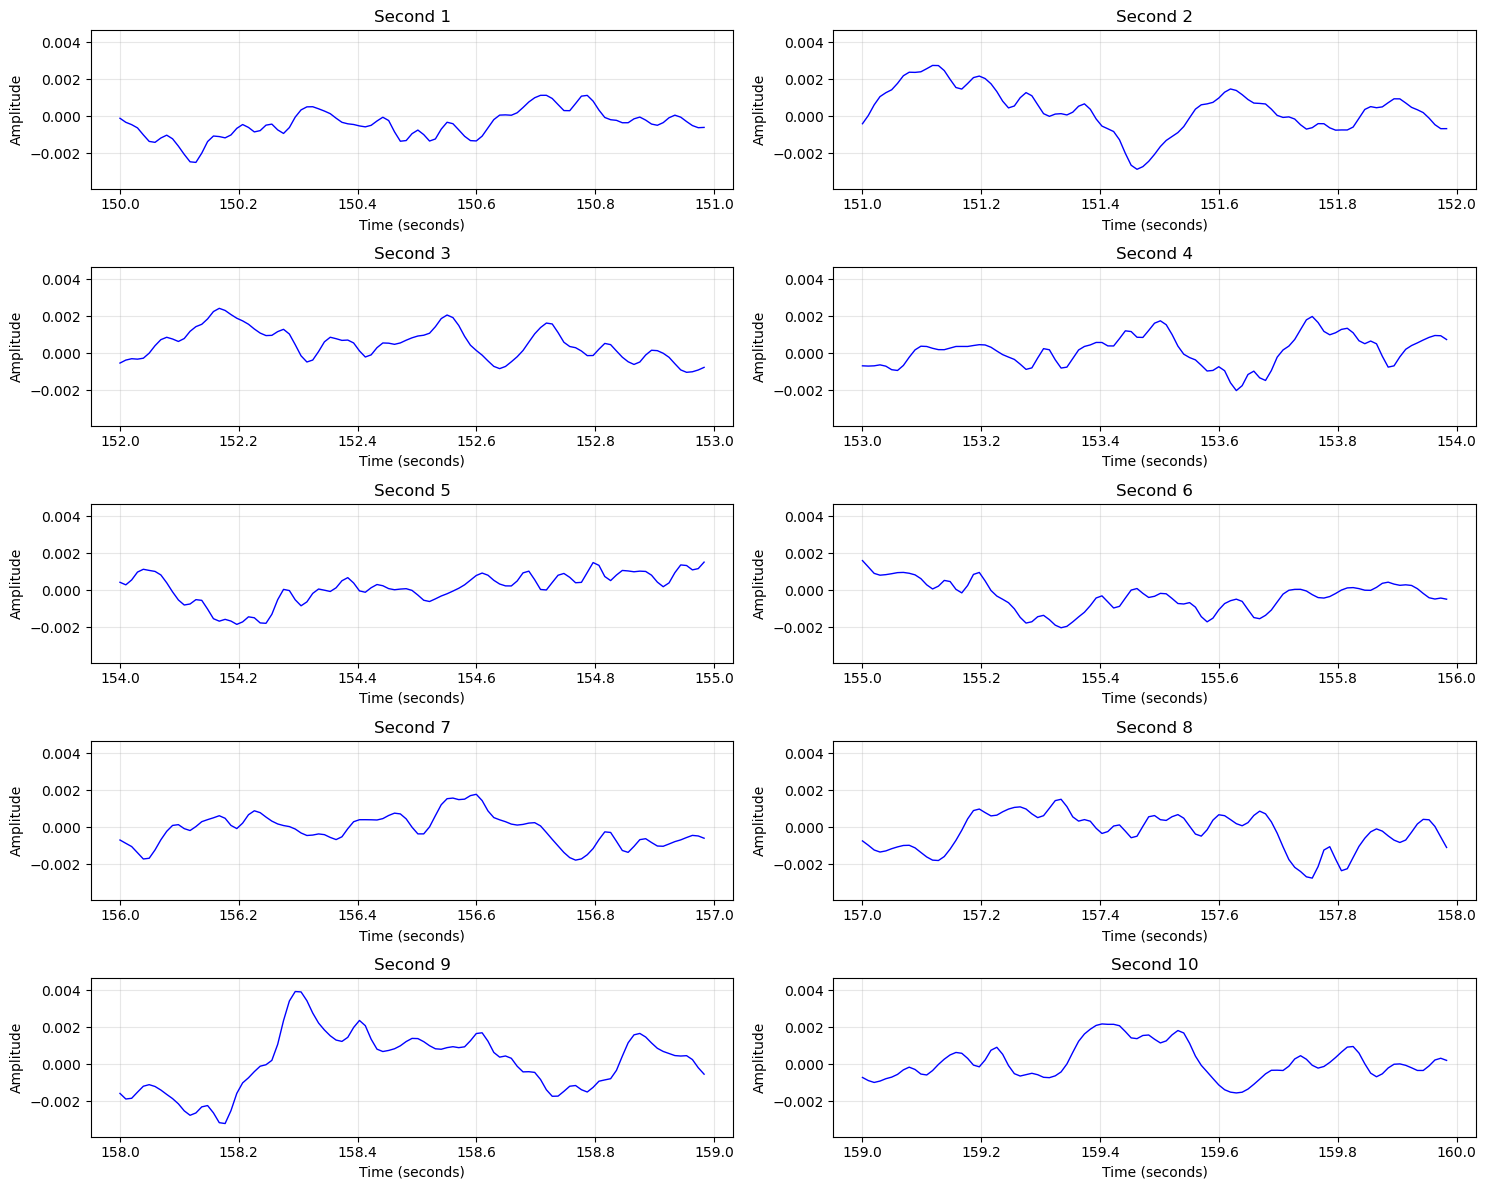

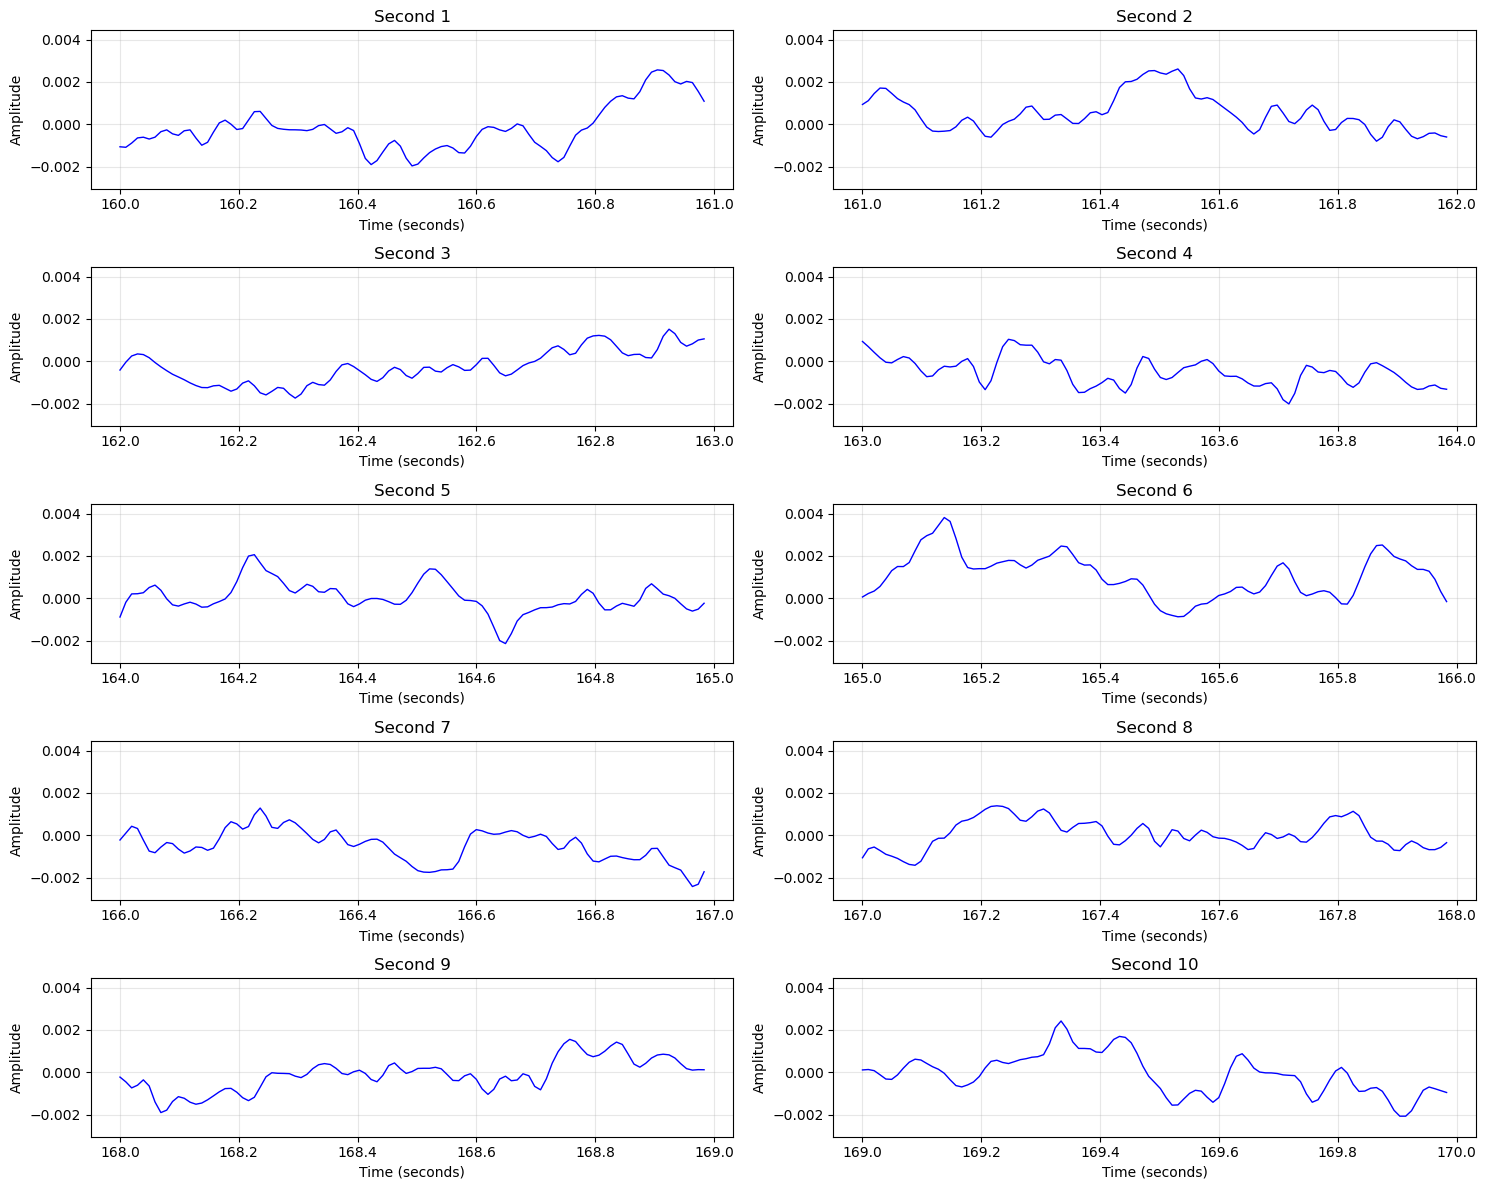

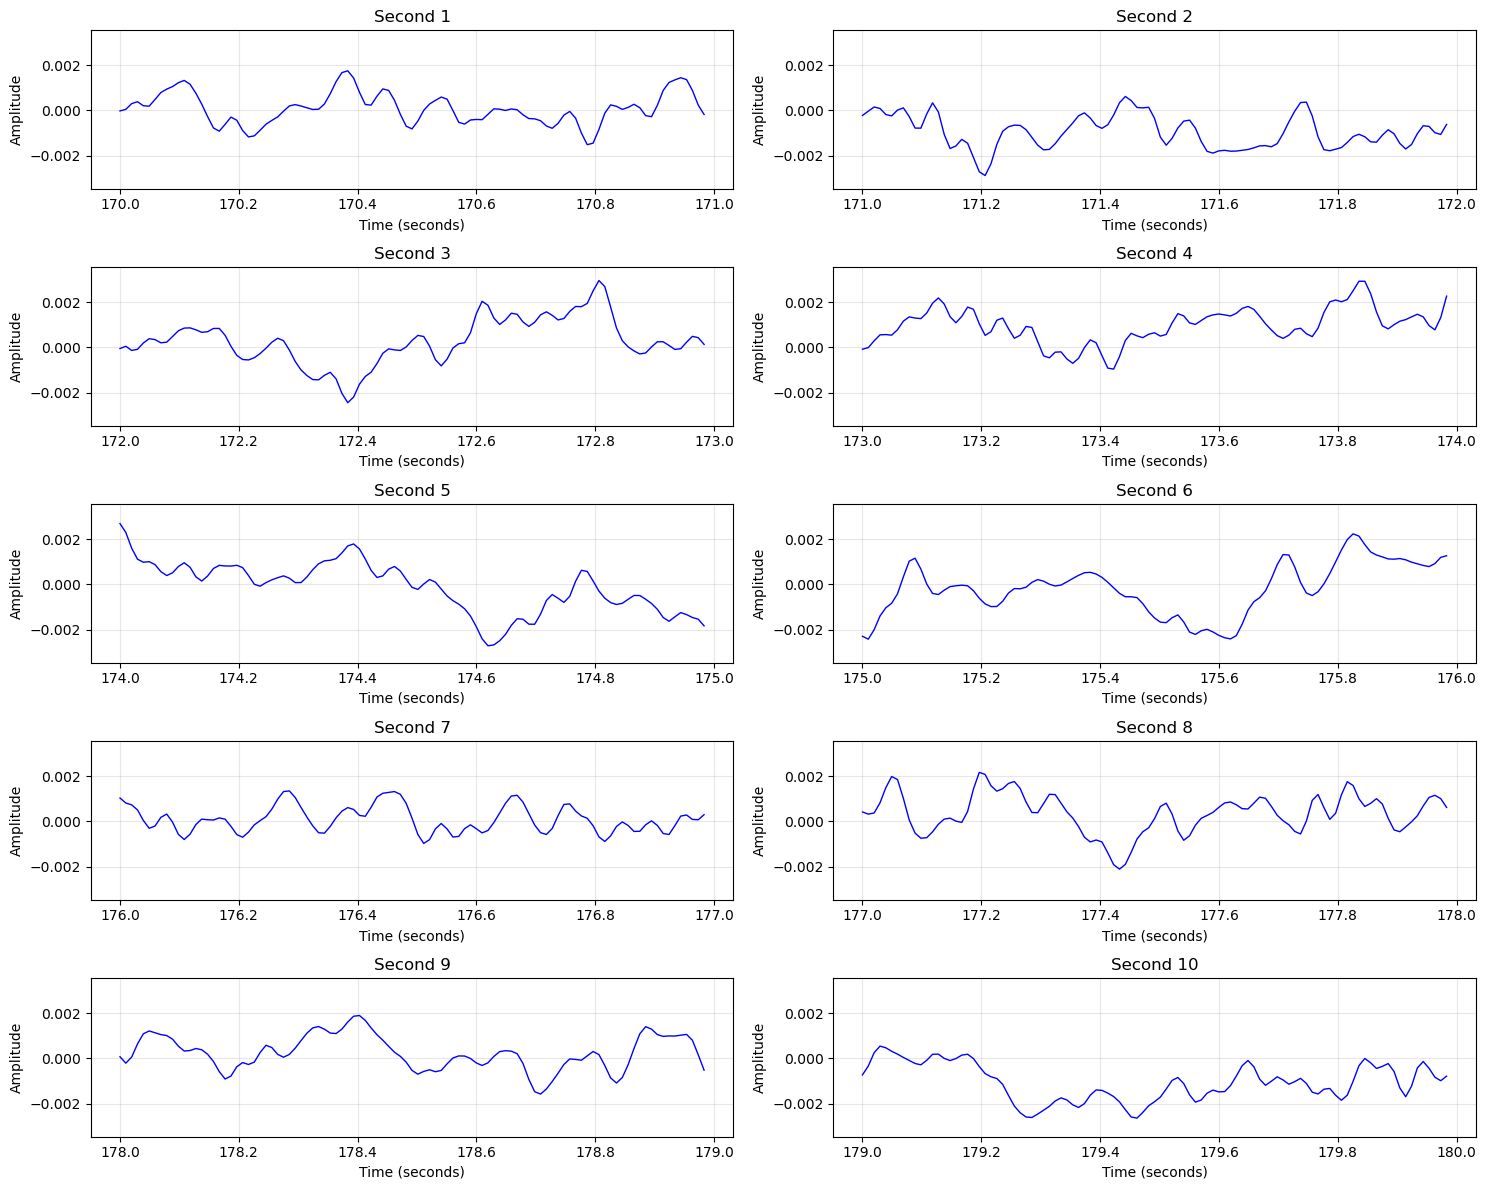

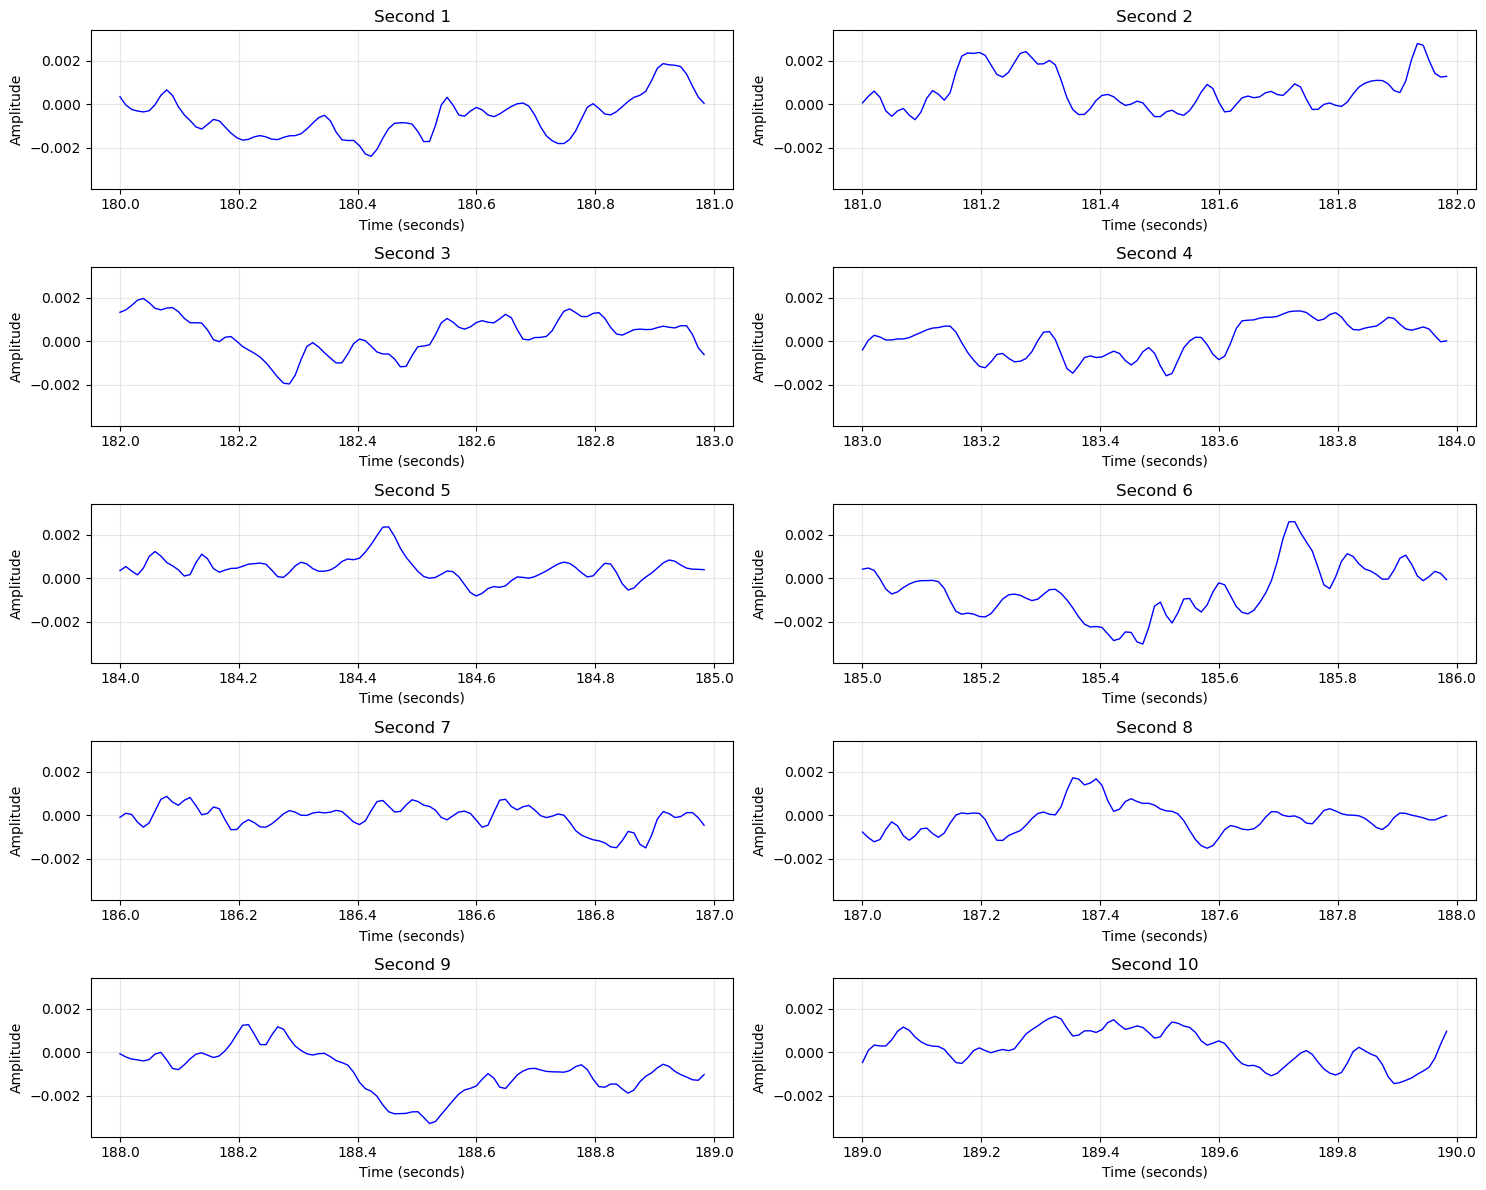

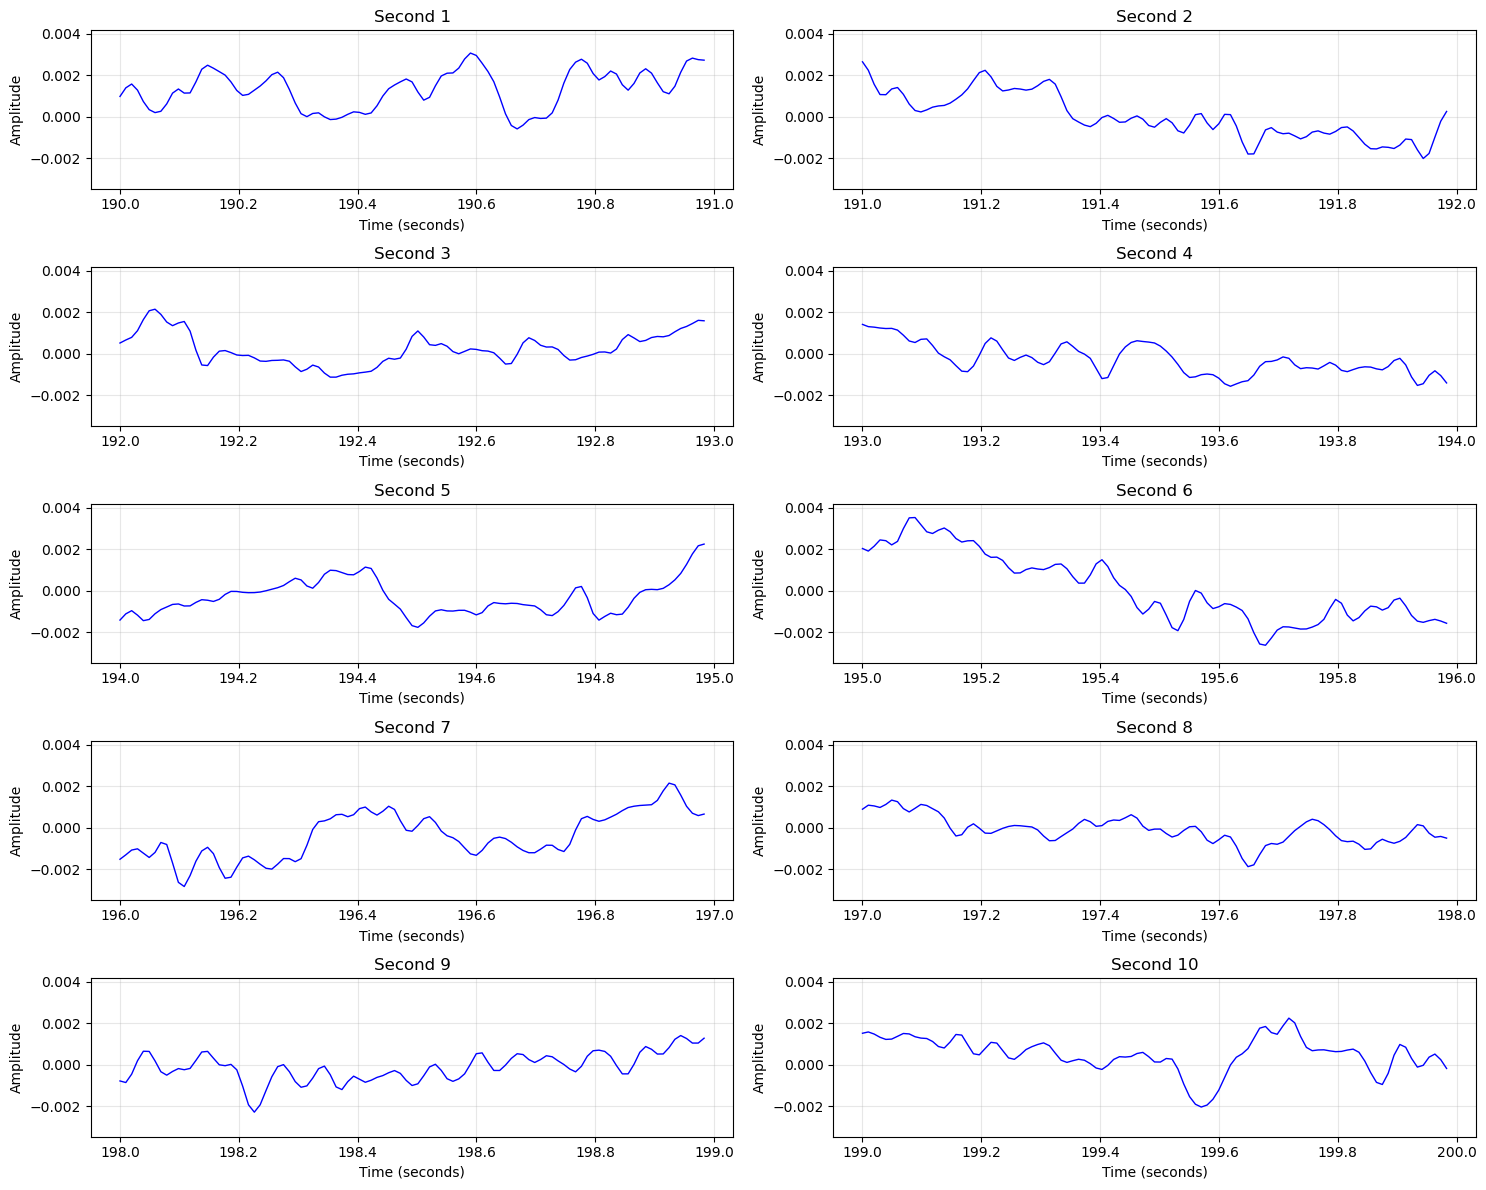

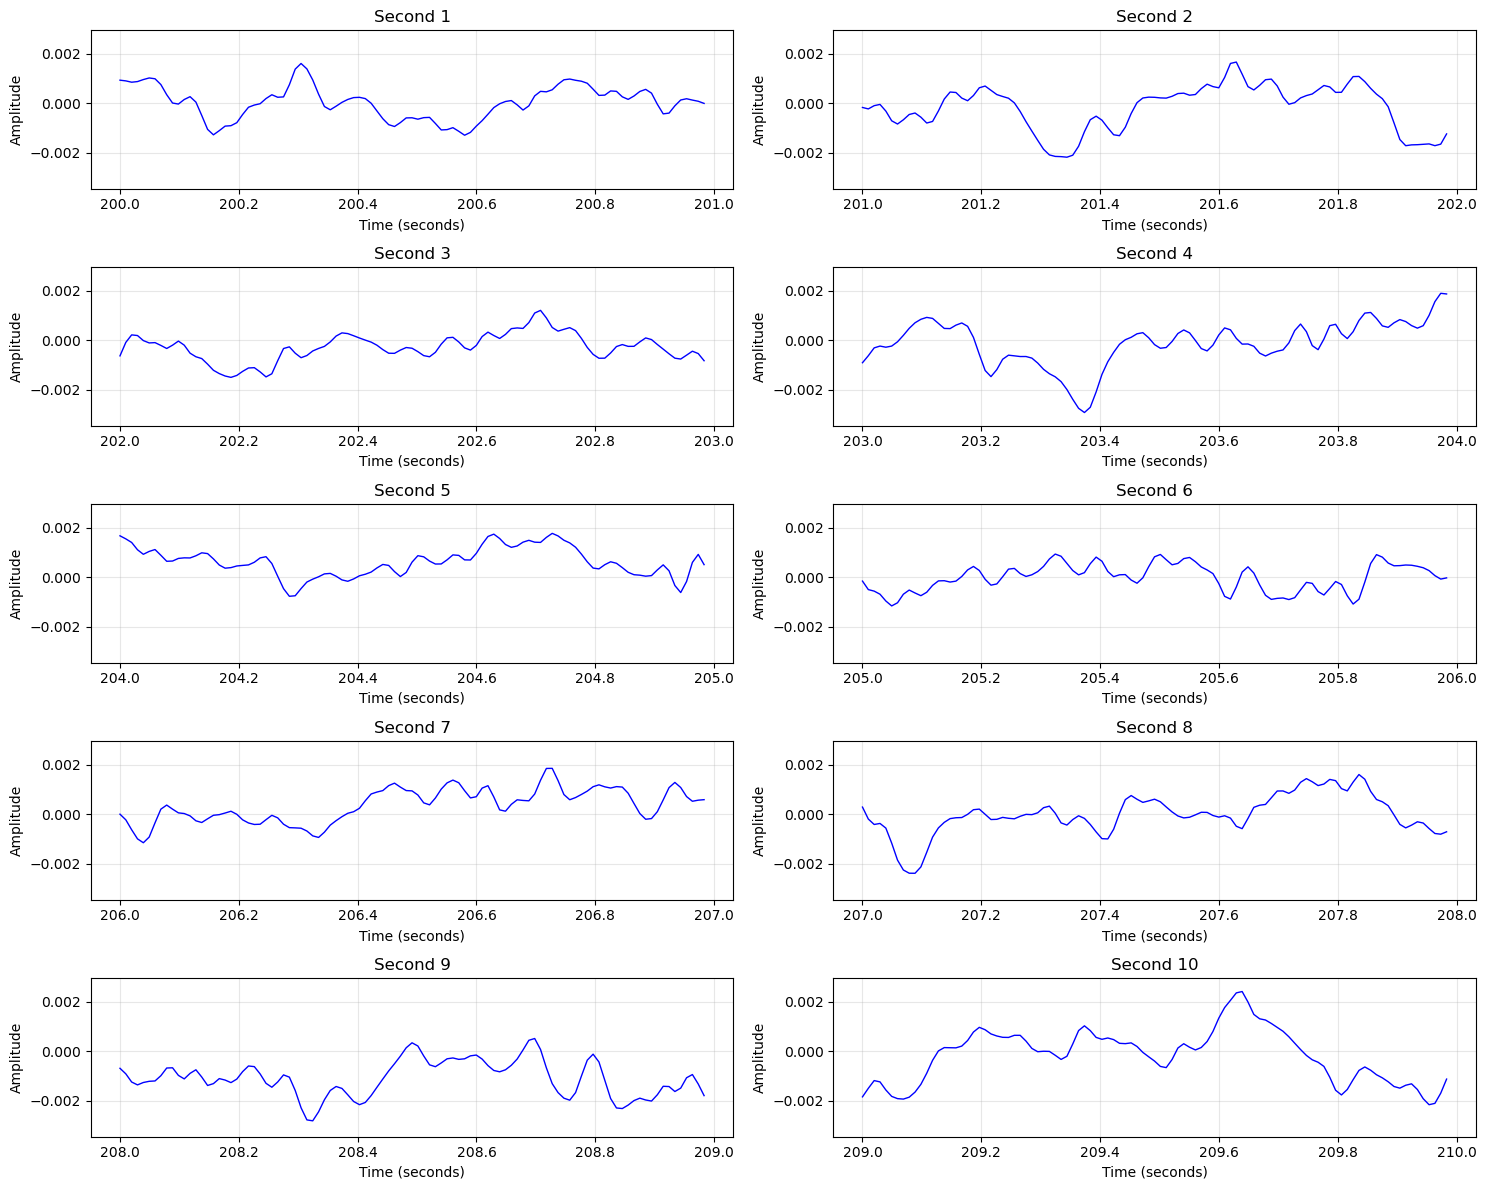

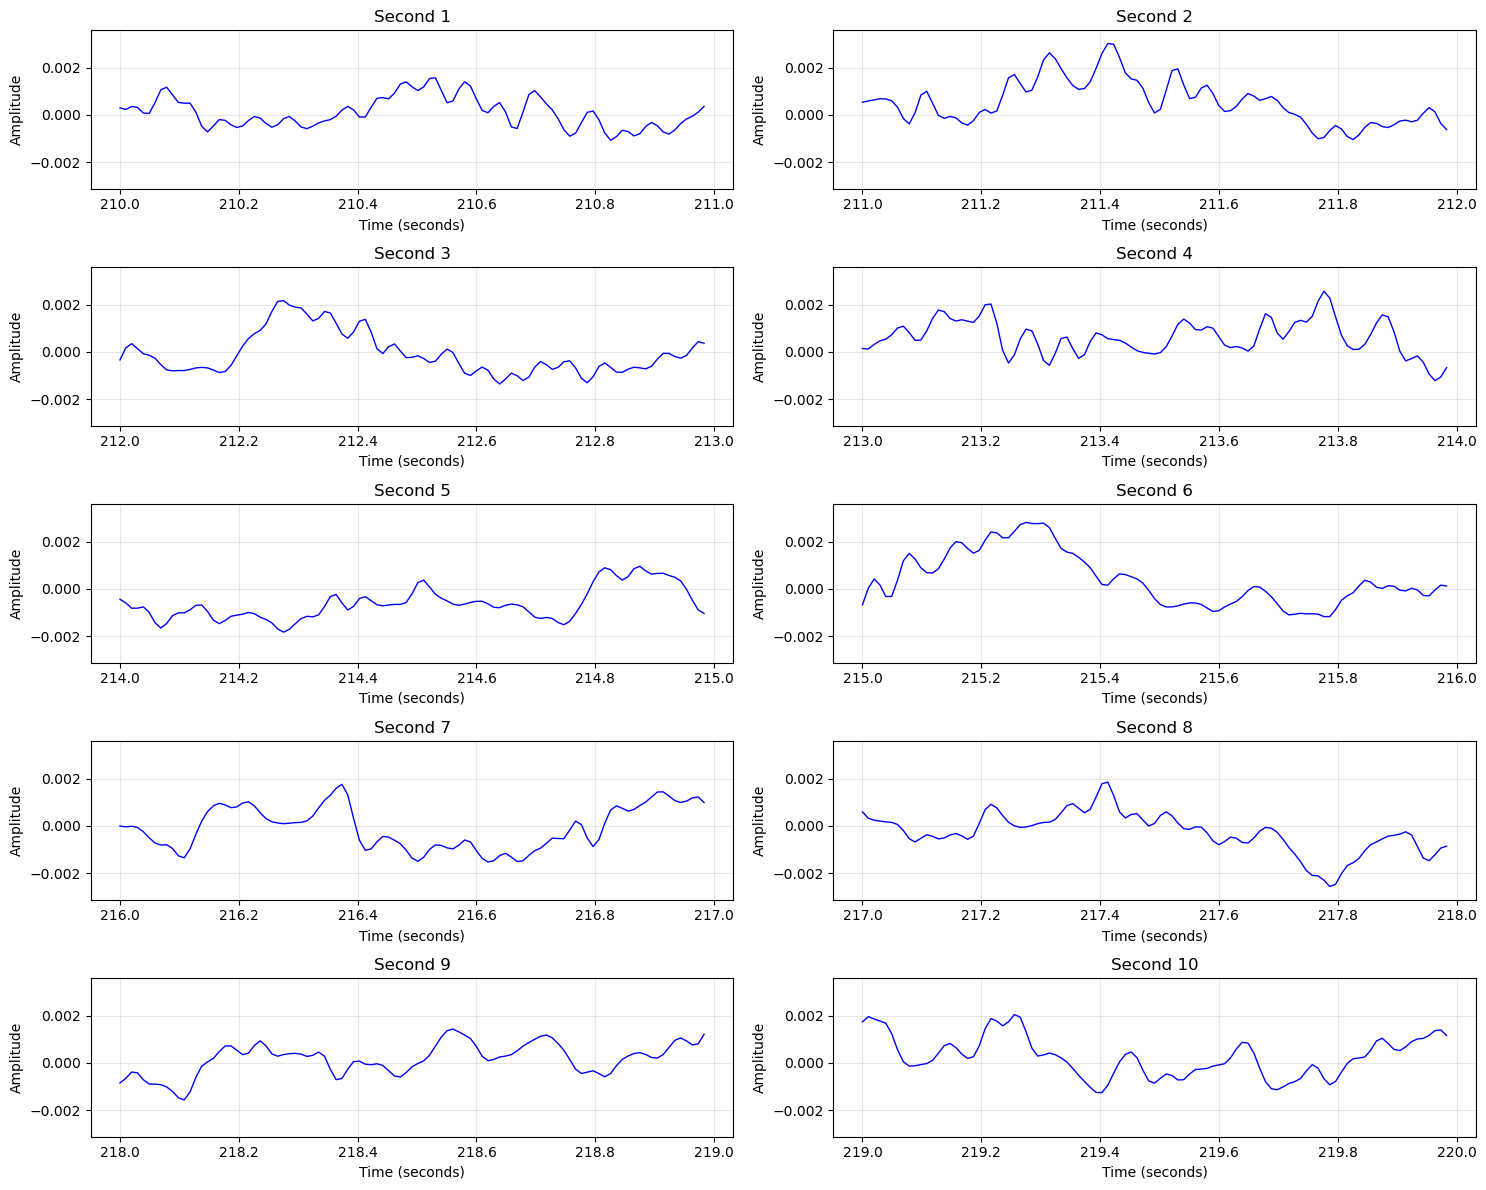

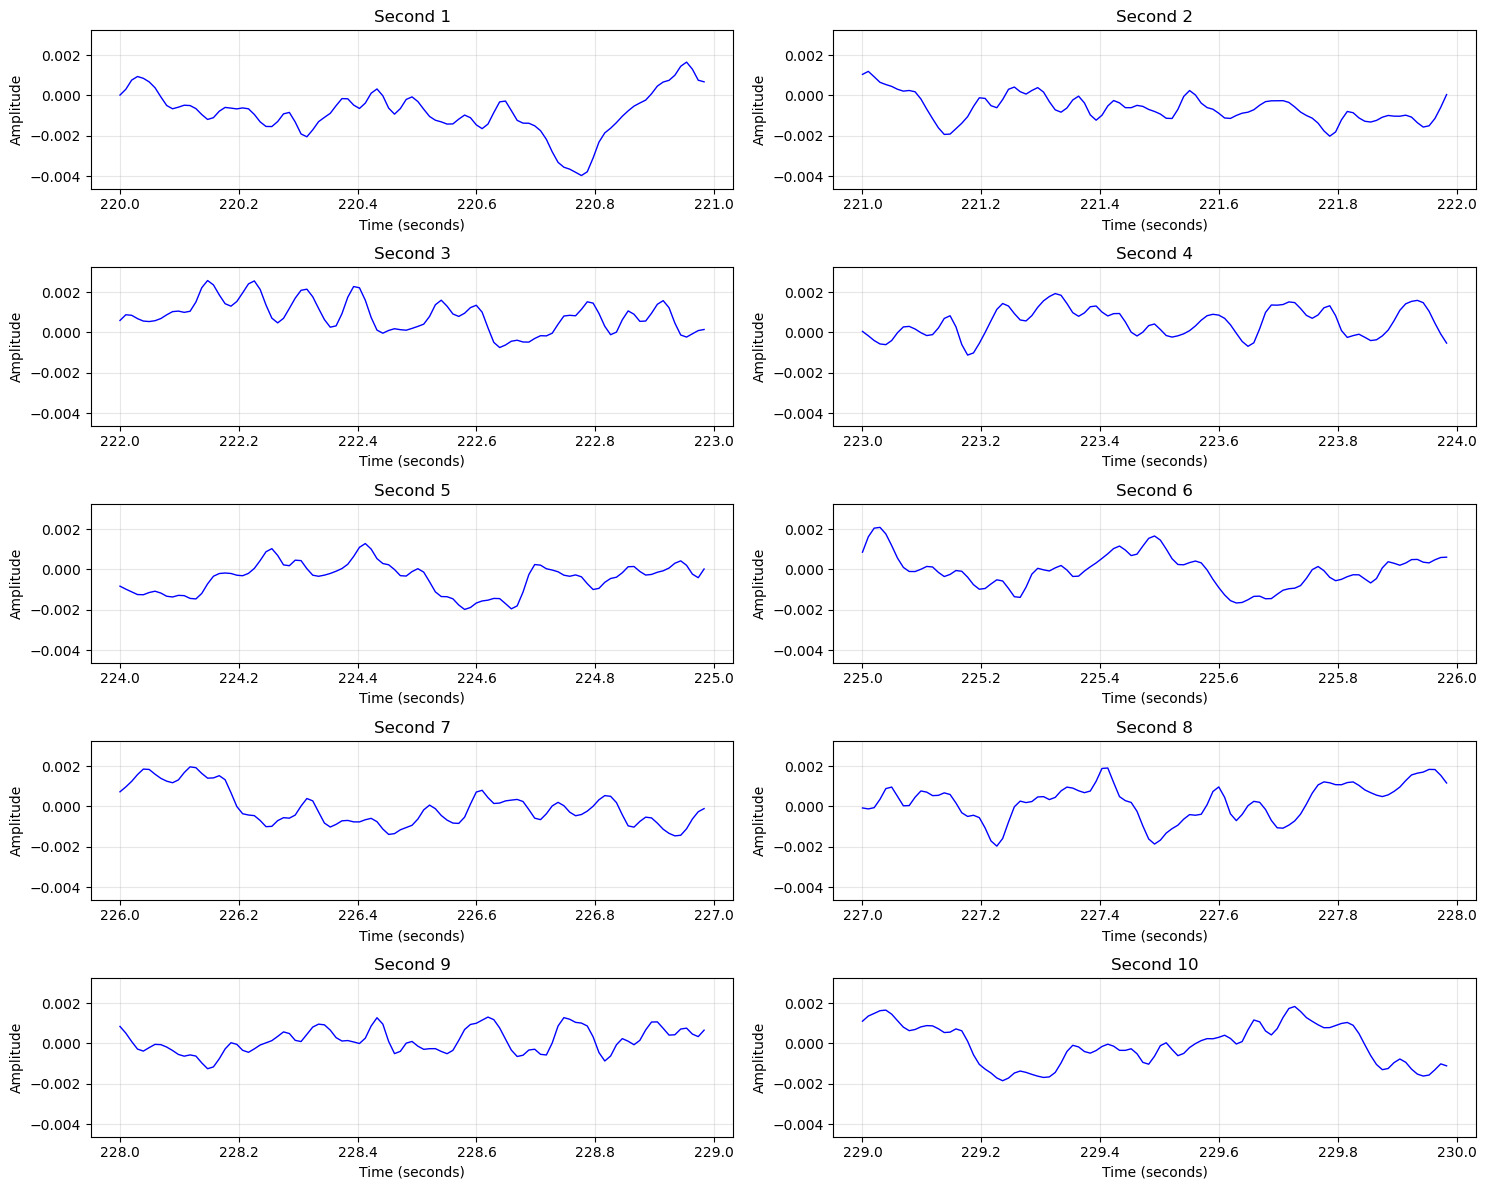

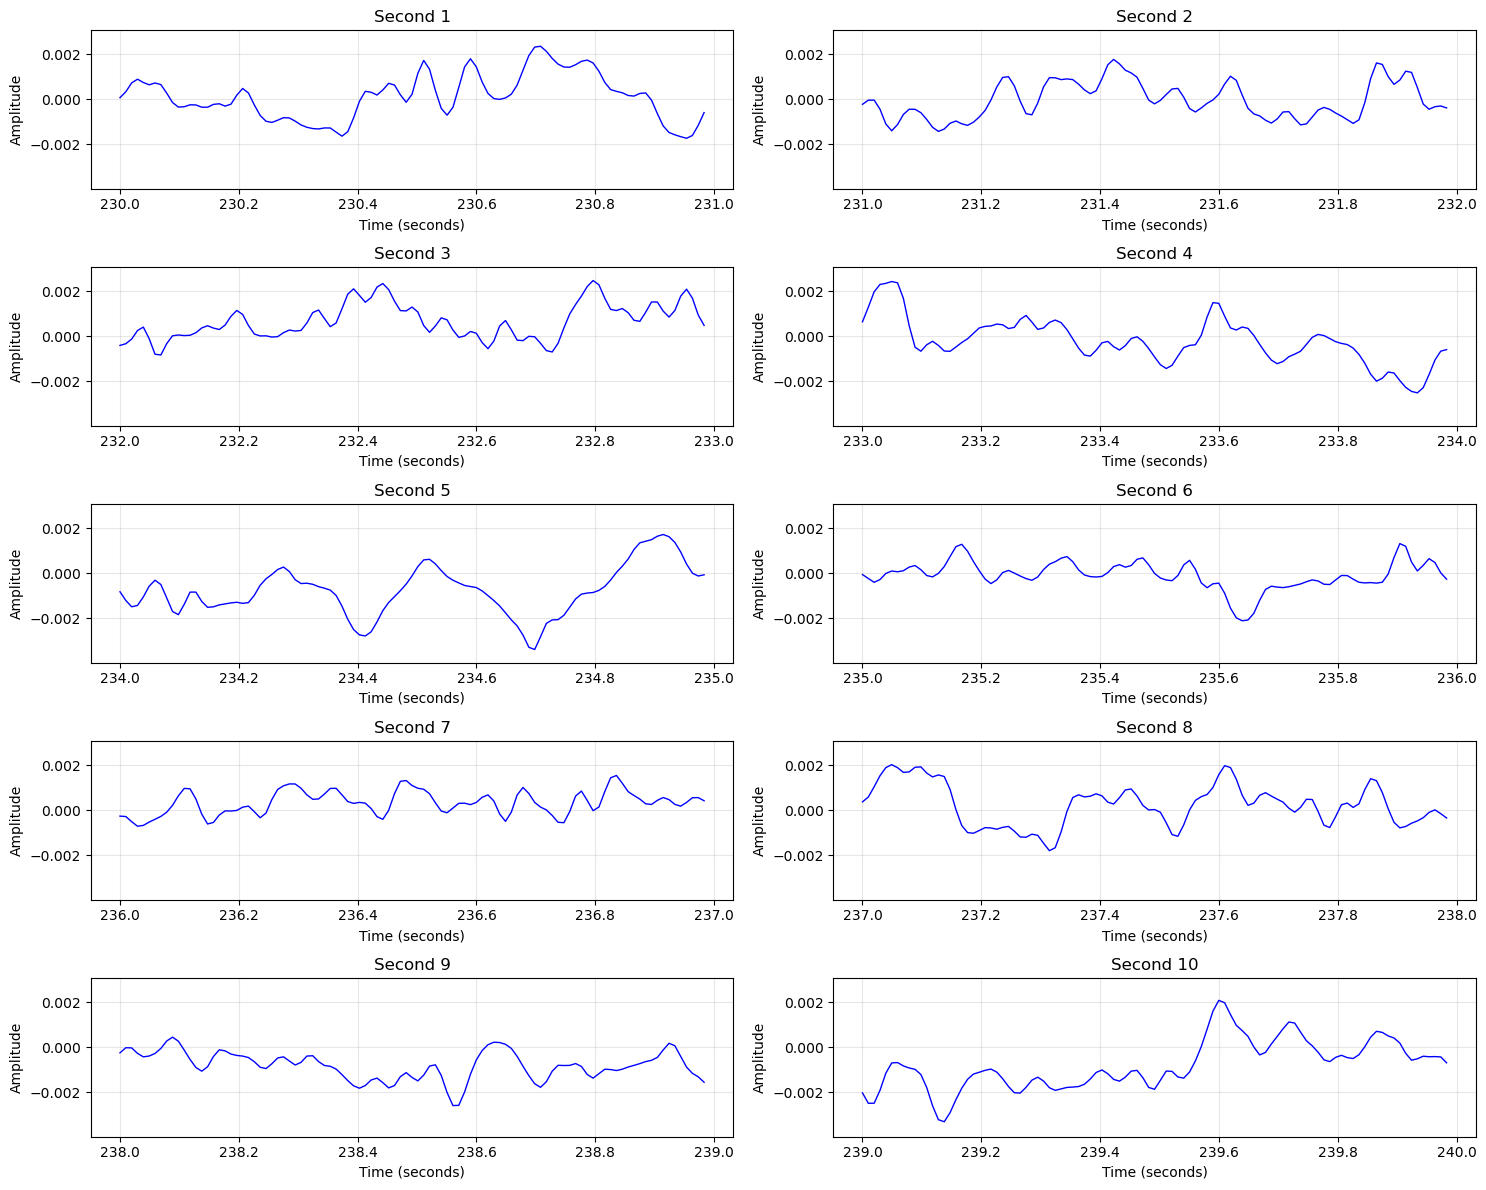

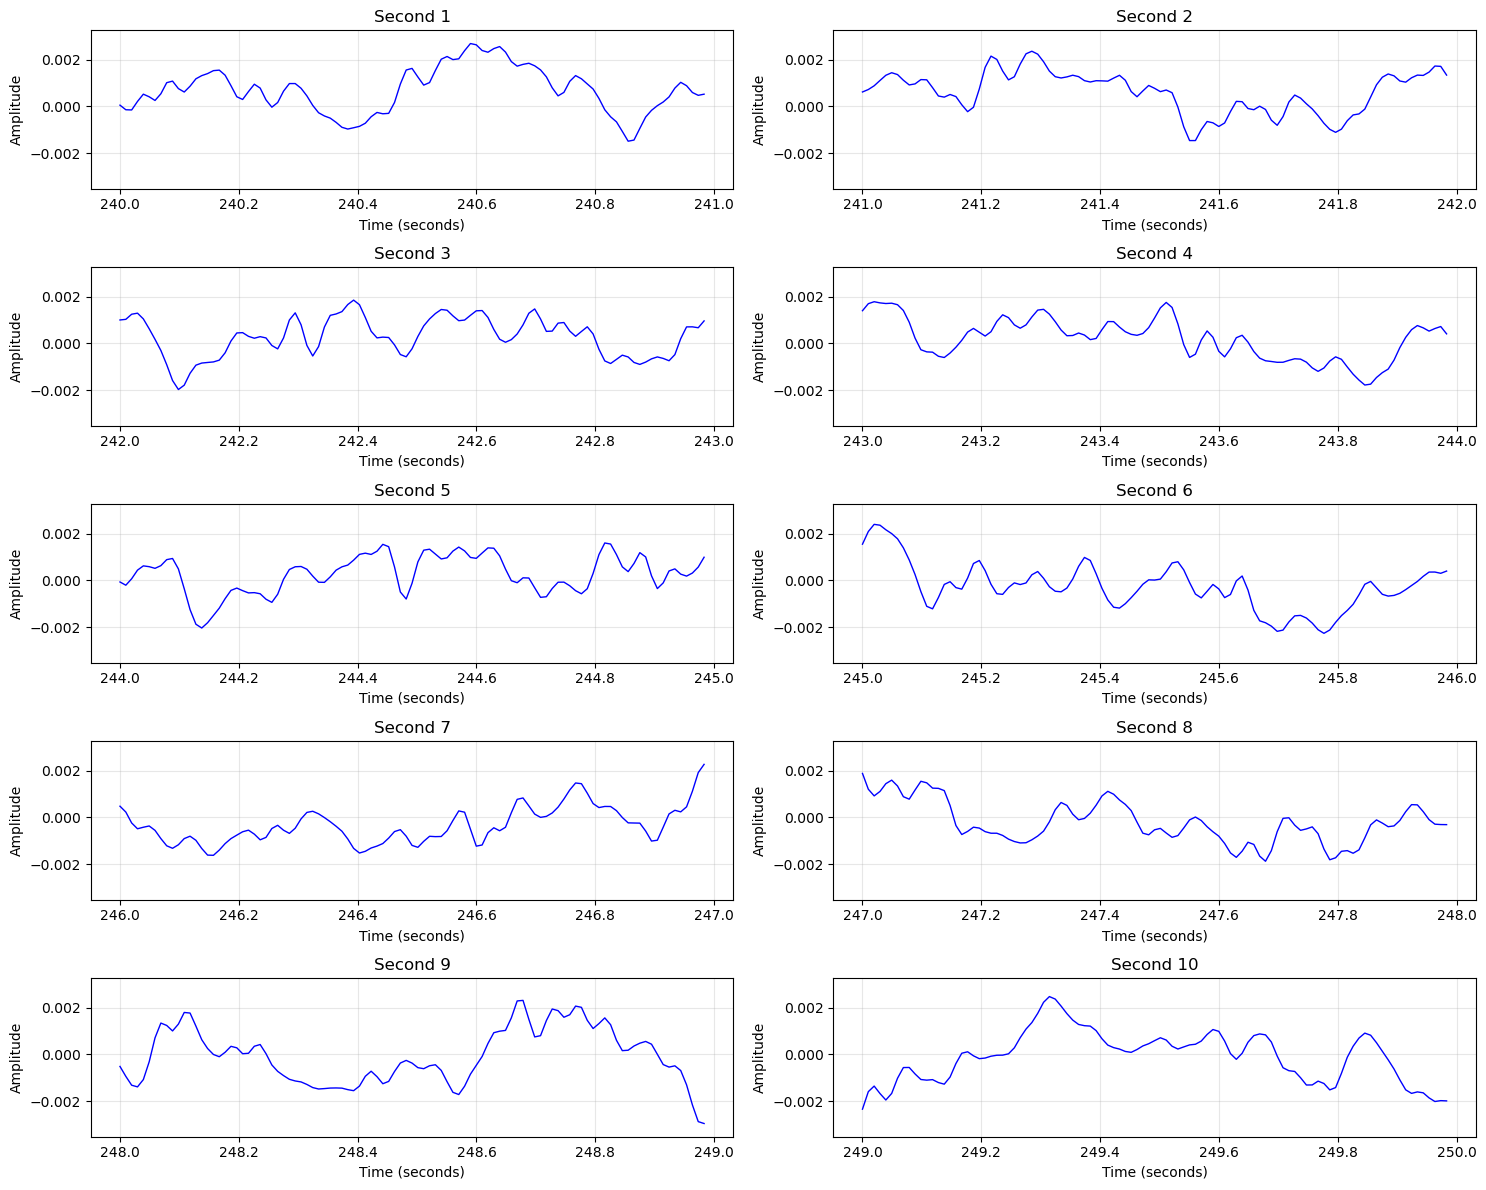

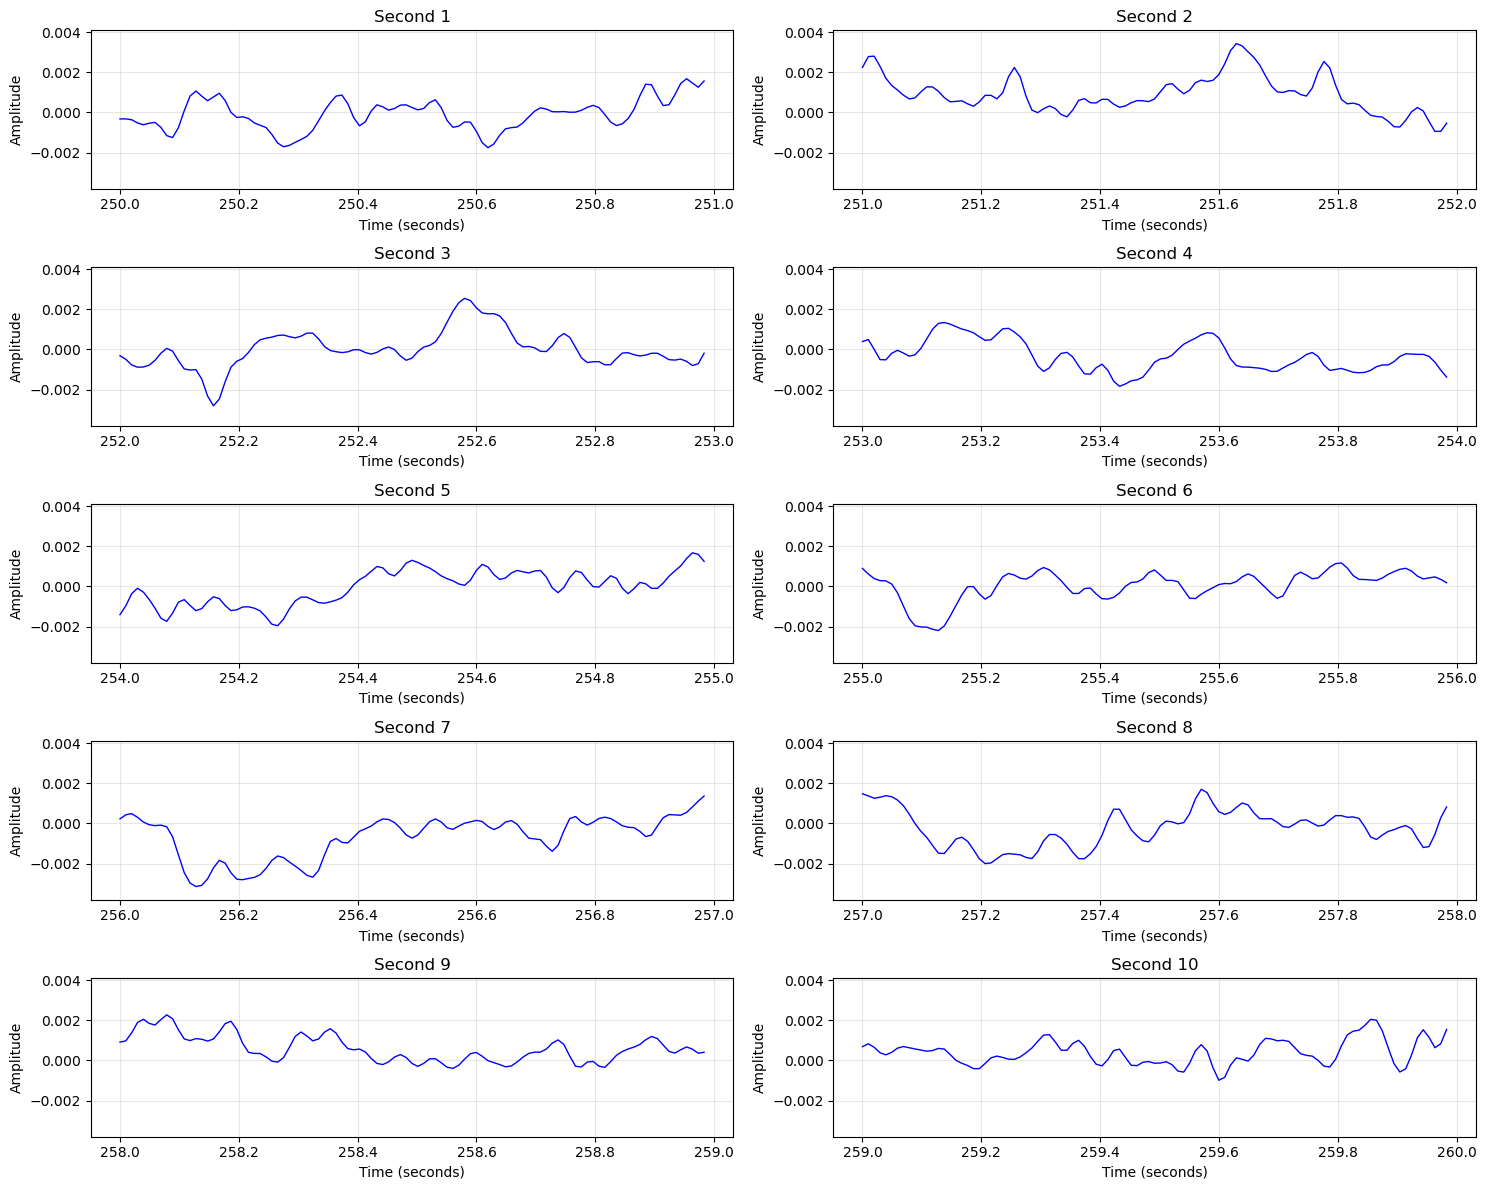

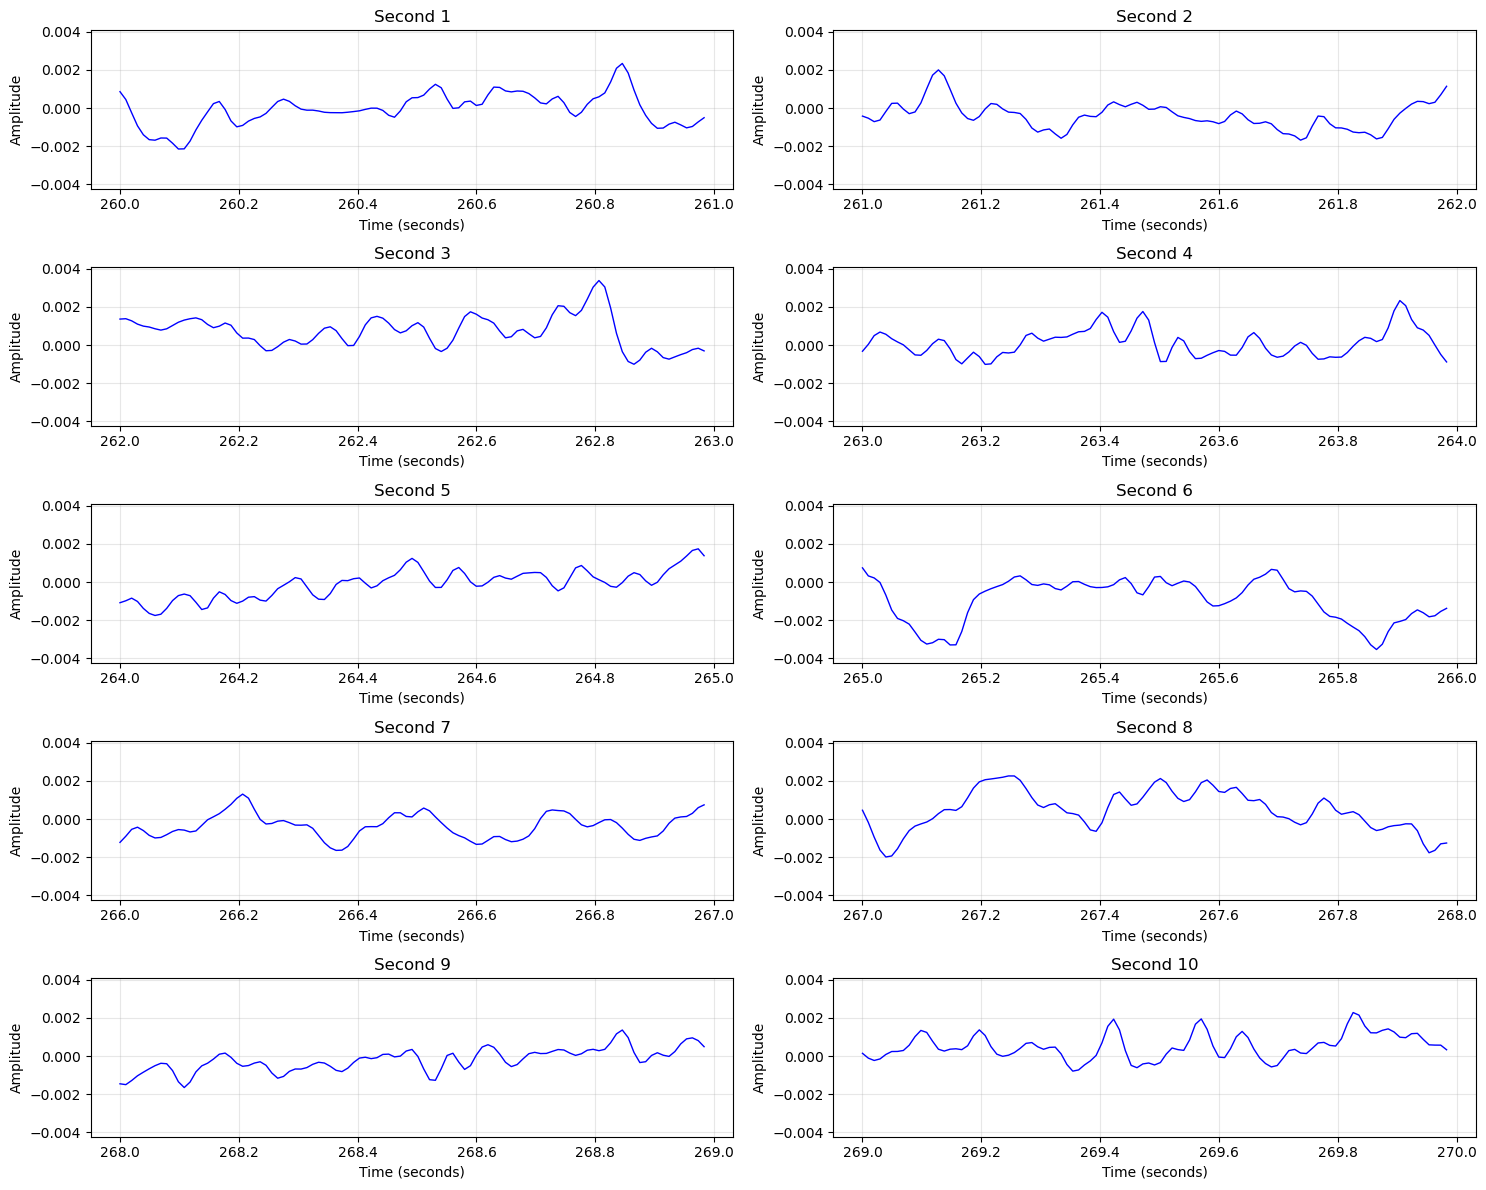

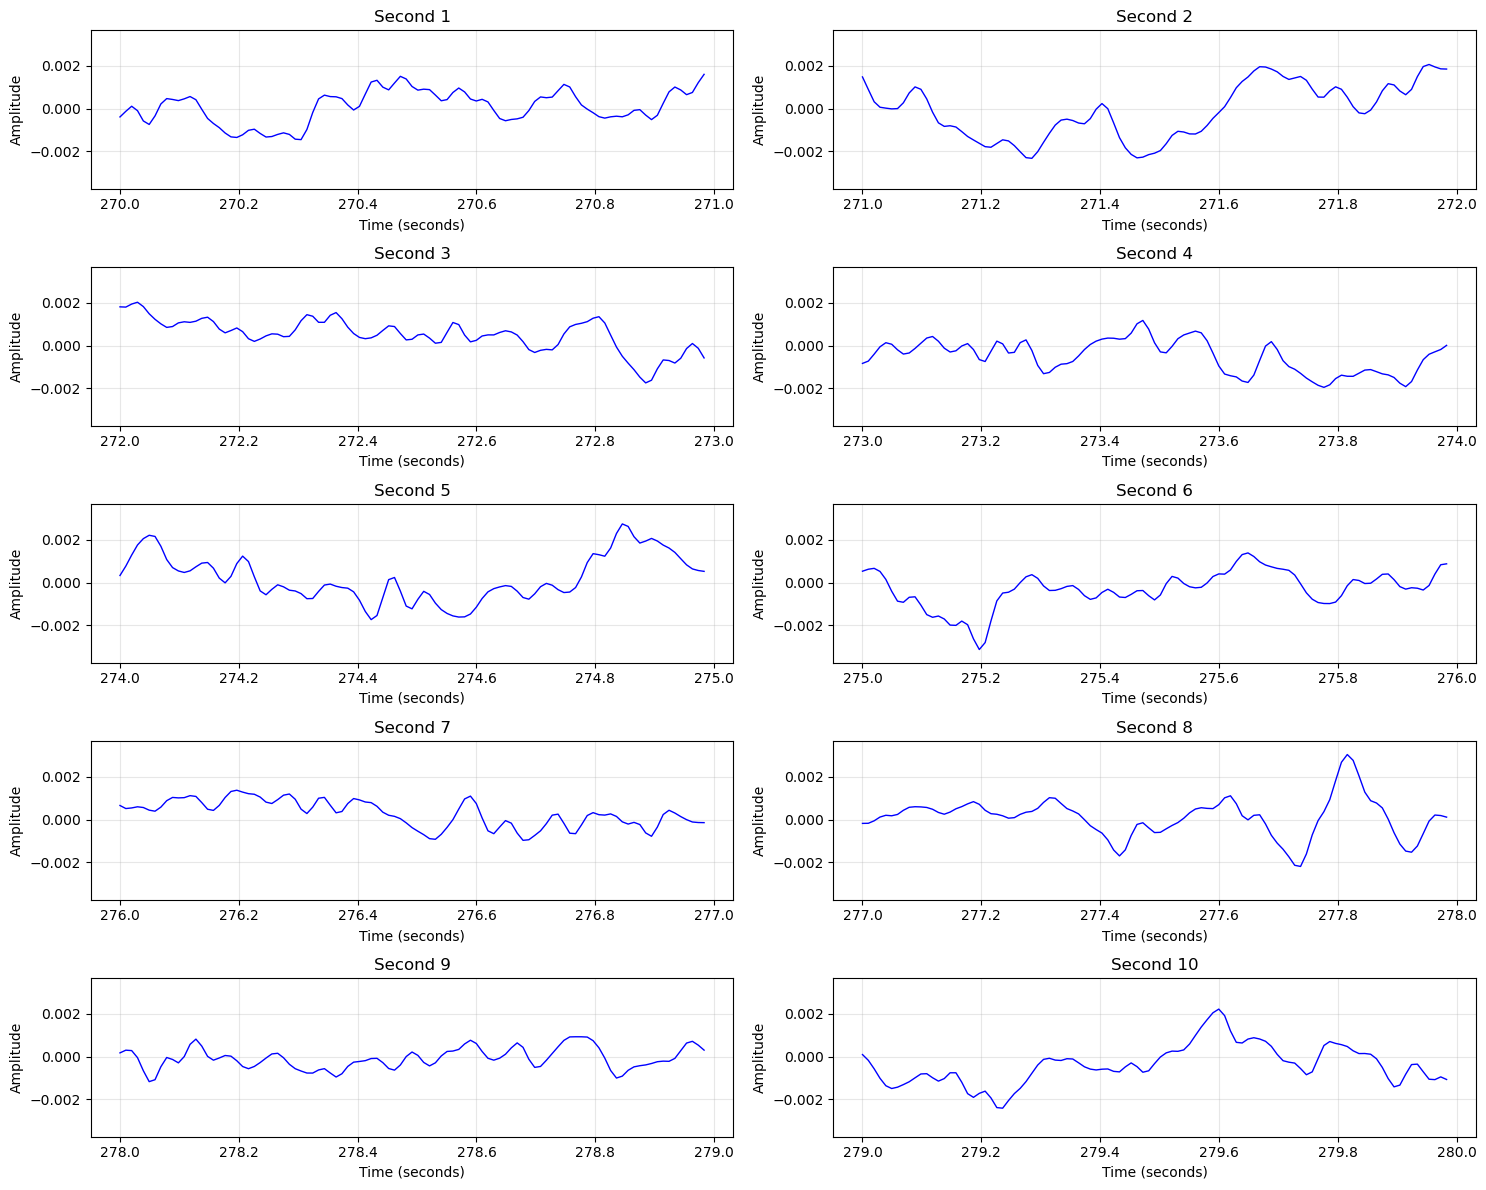

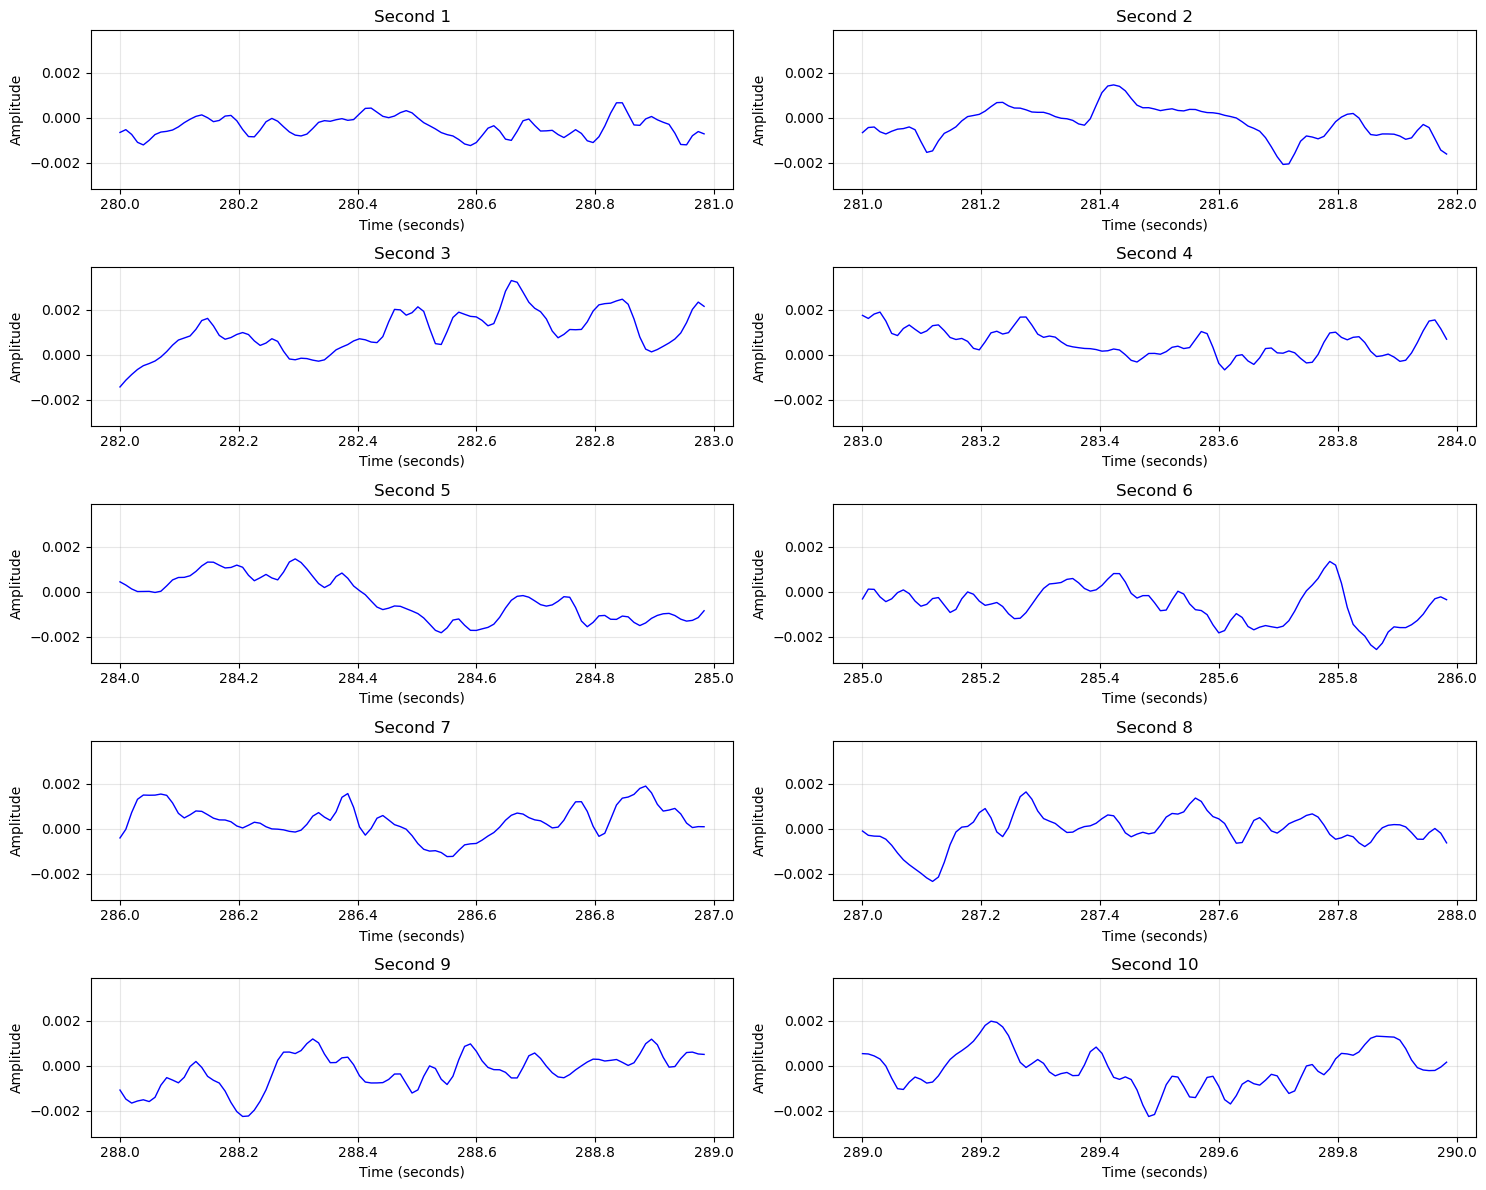

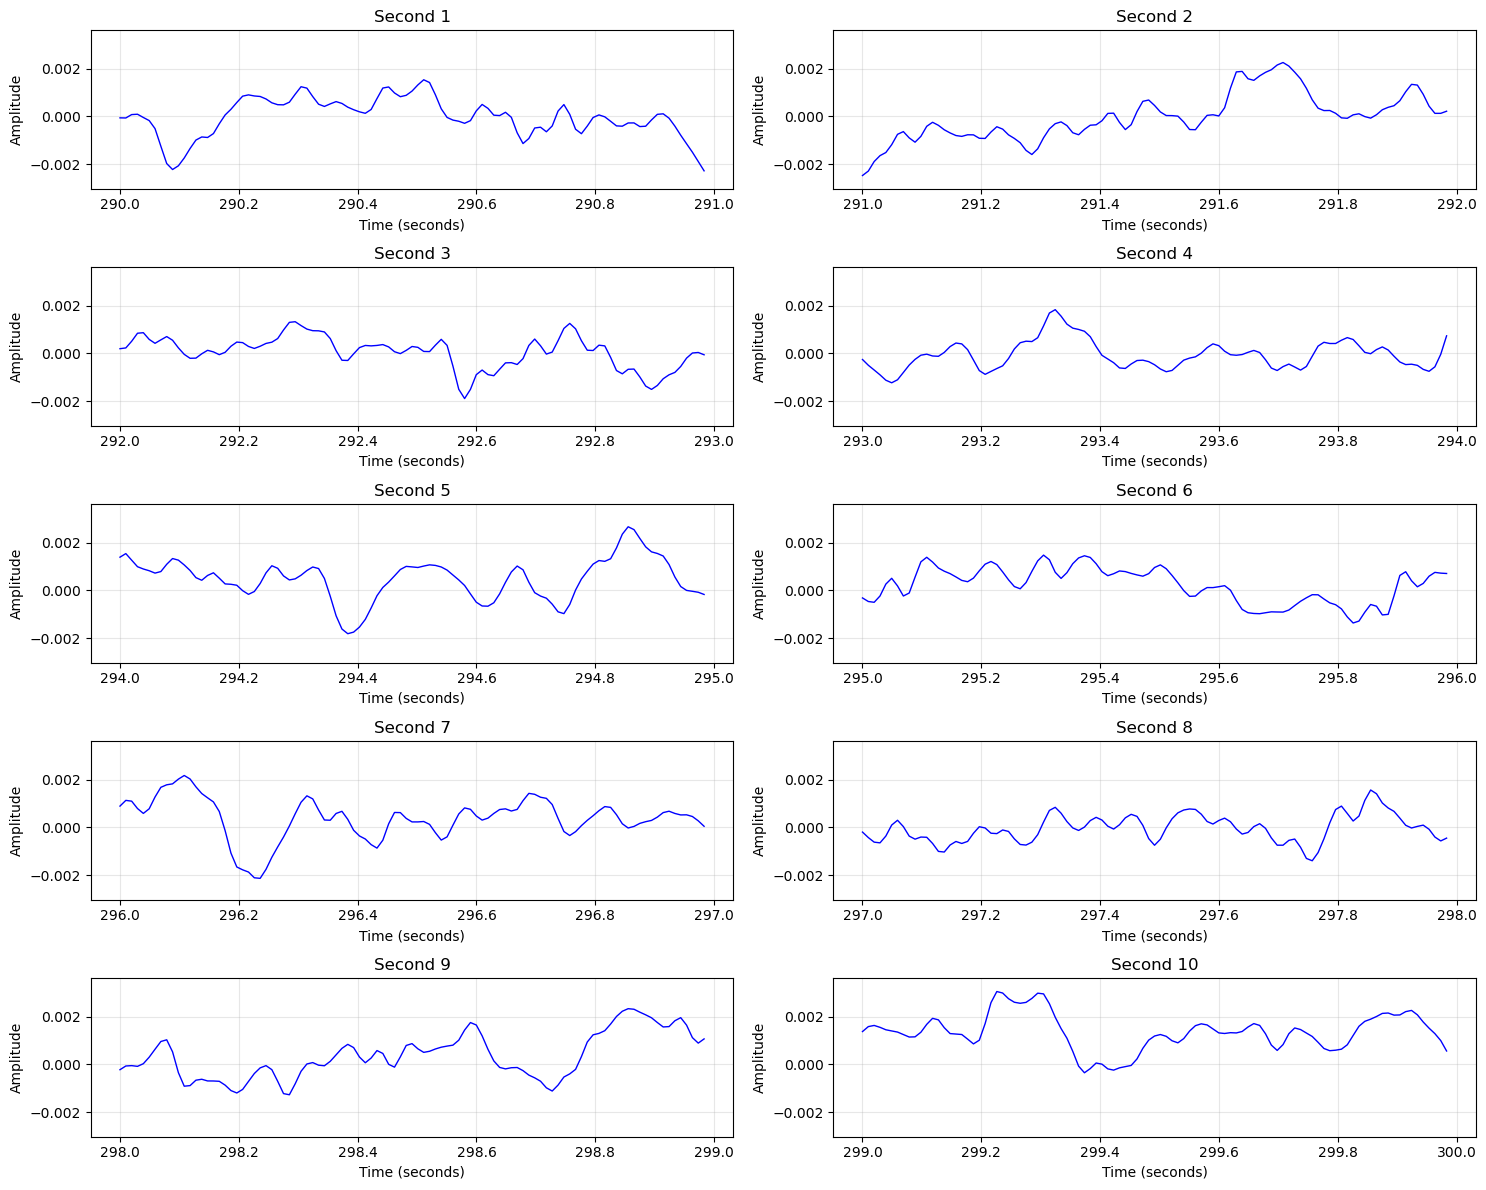

In [100]:
import resp_plotting
import importlib
import numpy as np

# Reload your plotting module
importlib.reload(resp_plotting)

# Define the 10-second chunk size
chunk_size = 10  # seconds
n_samples_per_chunk = int(chunk_size * fs)  # Number of samples per 10 seconds

# Loop to plot each 10-second chunk
n_chunks = len(rsp_cleaned) // n_samples_per_chunk  # Number of complete 10-second chunks

for i in range(n_chunks):
    start_index = i * n_samples_per_chunk
    end_index = (i + 1) * n_samples_per_chunk
    rsp_chunk = rsp_cleaned[start_index:end_index]
    
    # Use your resp_plotting function to plot each chunk
    resp_plotting.plot_respiratory_data_by_second(rsp_chunk, fs, start_time=start_time + i * chunk_size)
